### Basic neural activity analysis with single camera tracking
#### analyze the firing rate PC1,2,3
#### making the demo videos
#### the following detailed analysis focused on pull related behavioral events
#### the pull action start events are defined based on the movement onset before each pull
#### capture the entire section of neural activity from Pull Start/Onset to pull actions
#### This is the same analysis as basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartToPull_section_continuousBhv; but change to first project all possible continuous variables on PC space, then define based on PC1 (maybe PC2 as well)

In [1]:
# note:
# need to use pyddm environment to run this to be compitable with the hddm pipeline 

In [2]:
import pandas as pd
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.gridspec as gridspec
import seaborn
import scipy
import scipy.stats as st
import scipy.io
from sklearn.neighbors import KernelDensity
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import string
import warnings
import pickle
import json

from scipy.ndimage import gaussian_filter1d

import os
import glob
import random
from time import time

from scipy.ndimage import label


### function - get body part location for each pair of cameras

In [3]:
from ana_functions.body_part_locs_eachpair import body_part_locs_eachpair
from ana_functions.body_part_locs_singlecam import body_part_locs_singlecam

### function - align the two cameras

In [4]:
from ana_functions.camera_align import camera_align       

### function - merge the two pairs of cameras

In [5]:
from ana_functions.camera_merge import camera_merge

### function - find social gaze time point

In [6]:
from ana_functions.find_socialgaze_timepoint import find_socialgaze_timepoint
from ana_functions.find_socialgaze_timepoint_singlecam import find_socialgaze_timepoint_singlecam
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody import find_socialgaze_timepoint_singlecam_wholebody
from ana_functions.find_socialgaze_timepoint_singlecam_wholebody_2 import find_socialgaze_timepoint_singlecam_wholebody_2


### function - define time point of behavioral events

In [7]:
from ana_functions.bhv_events_timepoint import bhv_events_timepoint
from ana_functions.bhv_events_timepoint_singlecam import bhv_events_timepoint_singlecam

### function - plot behavioral events

In [8]:
from ana_functions.plot_bhv_events import plot_bhv_events
from ana_functions.plot_bhv_events_levertube import plot_bhv_events_levertube
from ana_functions.plot_continuous_bhv_var_singlecam_PullStartToPull_variedSection import plot_continuous_bhv_var_singlecam_PullStartToPull_variedSection
from ana_functions.plot_continuous_bhv_var_singlecam_PullStartToPull_variedSection_highbhvDimension_to_lowPCspace import plot_continuous_bhv_var_singlecam_PullStartToPull_variedSection_highbhvDimension_to_lowPCspace

from ana_functions.draw_self_loop import draw_self_loop
import matplotlib.patches as mpatches 
from matplotlib.collections import PatchCollection

### function - plot inter-pull interval

In [9]:
from ana_functions.plot_interpull_interval import plot_interpull_interval

### function - make demo videos with skeleton and inportant vectors

In [10]:
from ana_functions.tracking_video_singlecam_demo import tracking_video_singlecam_demo
from ana_functions.tracking_video_singlecam_wholebody_demo import tracking_video_singlecam_wholebody_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_demo import tracking_video_singlecam_wholebody_withNeuron_demo
from ana_functions.tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_video_singlecam_wholebody_withNeuron_sepbhv_demo
from ana_functions.tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo import tracking_frame_singlecam_wholebody_withNeuron_sepbhv_demo

### function - interval between all behavioral events

In [11]:
from ana_functions.bhv_events_interval import bhv_events_interval

### function - spike analysis

In [12]:
from ana_functions.spike_analysis_FR_calculation import spike_analysis_FR_calculation
from ana_functions.plot_spike_triggered_singlecam_bhvevent import plot_spike_triggered_singlecam_bhvevent
from ana_functions.plot_bhv_events_aligned_FR_PullStartToPull_variedSection import plot_bhv_events_aligned_FR_PullStartToPull_variedSection
from ana_functions.plot_strategy_aligned_FR import plot_strategy_aligned_FR

### function - PCA projection

In [13]:
from ana_functions.PCA_around_bhv_events import PCA_around_bhv_events
from ana_functions.PCA_around_bhv_events_video import PCA_around_bhv_events_video
from ana_functions.confidence_ellipse import confidence_ellipse

### function - other useful functions

In [14]:
# for projecting high D bhv variables to small PC space
from ana_functions.singlecam_conBhv_from_highDimension_to_PCspace import get_data_for_singlecam_conBhv_from_highDimension_to_PCspace

In [15]:
# for defining the meaningful social gaze (the continuous gaze distribution that is closest to the pull) 
from ana_functions.keep_closest_cluster_single_trial import keep_closest_cluster_single_trial

In [16]:
# get useful information about pulls
from ana_functions.get_pull_infos import get_pull_infos

In [17]:
# use the gaze vector speed and face mass speed to find the pull action start time within IPI
from ana_functions.find_sharp_increases_withinIPI import find_sharp_increases_withinIPI
from ana_functions.find_sharp_increases_withinIPI import find_sharp_increases_withinIPI_dual_speed

In [18]:
# method 2: find the lowest timepoint then the increase point as the pull onset
from ana_functions.find_rising_onset_after_min_withinIPI import find_rising_onset_after_min_withinIPI
from ana_functions.find_rising_onset_after_min_withinIPI import find_rising_onset_after_min_dual_speed

In [19]:
# method 2: find the lowest timepoint then the increase point as the pull onset
from ana_functions.find_rising_onset_after_min_withinIPI import find_rising_onset_after_min_withinIPI
from ana_functions.find_rising_onset_after_min_withinIPI import find_rising_onset_after_min_dual_speed

## Analyze each session

### prepare the basic behavioral data (especially the time stamps for each bhv events)

In [52]:
# instead of using gaze angle threshold, use the target rectagon to deside gaze info
# ...need to update
sqr_thres_tubelever = 75 # draw the square around tube and lever
sqr_thres_face = 1.15 # a ratio for defining face boundary
sqr_thres_body = 4 # how many times to enlongate the face box boundry to the body


# get the fps of the analyzed video
fps = 30

# get the fs for neural recording
fs_spikes = 20000
fs_lfp = 1000

# frame number of the demo video
nframes = 0.5*30 # second*30fps
# nframes = 45*30 # second*30fps

# re-analyze the video or not
reanalyze_video = 0
redo_anystep = 0

# if use onset of the first increase after min
doOnsetAfterMin = 1
if not doOnsetAfterMin:
    doOnsetAfterMin_suffix = 'bhvPCA_'
elif doOnsetAfterMin:
    doOnsetAfterMin_suffix = 'bhvPCA_PullOnsetAfterMin_'

# if use a hmm based method to find the trial start
doHMMmethod = 0
if doHMMmethod:
    doOnsetAfterMin_suffix = 'HMMmethods_'

    

# do OFC sessions or DLPFC sessions
do_OFC = 0
do_DLPFC  = 1
if do_OFC:
    savefile_sufix = '_OFCs'
elif do_DLPFC:
    savefile_sufix = '_DLPFCs'
else:
    savefile_sufix = ''
    
# all the videos (no misaligned ones)
# aligned with the audio
# get the session start time from "videosound_bhv_sync.py/.ipynb"
# currently the session_start_time will be manually typed in. It can be updated after a better method is used


# dodson ginger
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                    '20240531_Dodson_MC',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240603_Dodson_MC_and_SR',
                                    '20240604_Dodson_MC',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240605_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240606_Dodson_MC_and_SR',
                                    '20240607_Dodson_SR',
                                    '20240610_Dodson_MC',
                                    '20240611_Dodson_SR',
                                    '20240612_Dodson_MC',
                                    '20240613_Dodson_SR',
                                    '20240620_Dodson_SR',
                                    '20240719_Dodson_MC',
                                        
                                    '20250129_Dodson_MC',
                                    '20250130_Dodson_SR',
                                    '20250131_Dodson_MC',
                                
            
                                    '20250210_Dodson_SR_withKoala',
                                    '20250211_Dodson_MC_withKoala',
                                    '20250212_Dodson_SR_withKoala',
                                    '20250214_Dodson_MC_withKoala',
                                    '20250217_Dodson_SR_withKoala',
                                    '20250218_Dodson_MC_withKoala',
                                    '20250219_Dodson_SR_withKoala',
                                    '20250220_Dodson_MC_withKoala',
                                    '20250224_Dodson_KoalaAL_withKoala',
                                    '20250226_Dodson_MC_withKoala',
                                    '20250227_Dodson_KoalaAL_withKoala',
                                    '20250228_Dodson_DodsonAL_withKoala',
                                    '20250304_Dodson_DodsonAL_withKoala',
                                    '20250305_Dodson_MC_withKoala',
                                    '20250306_Dodson_KoalaAL_withKoala',
                                    '20250307_Dodson_DodsonAL_withKoala',
                                    '20250310_Dodson_MC_withKoala',
                                    '20250312_Dodson_NV_withKoala',
                                    '20250313_Dodson_NV_withKoala',
                                    '20250314_Dodson_NV_withKoala',
            
                                    '20250401_Dodson_MC_withKanga',
                                    '20250402_Dodson_MC_withKanga',
                                    '20250403_Dodson_MC_withKanga',
                                    '20250404_Dodson_SR_withKanga',
                                    '20250407_Dodson_SR_withKanga',
                                    '20250408_Dodson_SR_withKanga',
                                    '20250409_Dodson_MC_withKanga',
            
                                    '20250415_Dodson_MC_withKanga',
                                    # '20250416_Dodson_SR_withKanga', # has to remove from the later analysis, recording has problems
                                    '20250417_Dodson_MC_withKanga',
                                    '20250418_Dodson_SR_withKanga',
                                    '20250421_Dodson_SR_withKanga',
                                    '20250422_Dodson_MC_withKanga',
                                    '20250422_Dodson_SR_withKanga',
            
                                    '20250423_Dodson_MC_withKanga',
                                    '20250423_Dodson_SR_withKanga', 
                                    '20250424_Dodson_NV_withKanga',
                                    '20250424_Dodson_MC_withKanga',
                                    '20250424_Dodson_SR_withKanga',            
                                    '20250425_Dodson_NV_withKanga',
                                    '20250425_Dodson_SR_withKanga',
                                    '20250428_Dodson_NV_withKanga',
                                    '20250428_Dodson_MC_withKanga',
                                    '20250428_Dodson_SR_withKanga',  
                                    '20250429_Dodson_NV_withKanga',
                                    '20250429_Dodson_MC_withKanga',
                                    '20250429_Dodson_SR_withKanga',  
                                    '20250430_Dodson_NV_withKanga',
                                    '20250430_Dodson_MC_withKanga',
                                    '20250430_Dodson_SR_withKanga',  
            
                                   ]
        task_conditions = [
                            'MC',           
                            'MC',
                            'SR',
                            'MC',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            'SR',
                            'MC',
                            'SR',
                            'SR',
                            'MC',
                            
                            'MC_withGingerNew',
                            'SR_withGingerNew',
                            'MC_withGingerNew',
            
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'SR_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'MC_KoalaAuto_withKoala',
                            'MC_DodsonAuto_withKoala',
                            'MC_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',
                            'NV_withKoala',

                            'MC_withKanga',
                            'MC_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
            
                            'MC_withKanga',
                            # 'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
                            'SR_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',
            
                            'MC_withKanga',
                            'SR_withKanga', 
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',            
                            'NV_withKanga',
                            'SR_withKanga',
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                            'NV_withKanga',
                            'MC_withKanga',
                            'SR_withKanga',  
                          ]
        dates_list = [
                        '20240531',
                        '20240603_MC',
                        '20240603_SR',
                        '20240604',
                        '20240605_MC',
                        '20240605_SR',
                        '20240606_MC',
                        '20240606_SR',
                        '20240607',
                        '20240610_MC',
                        '20240611',
                        '20240612',
                        '20240613',
                        '20240620',
                        '20240719',
            
                        '20250129',
                        '20250130',
                        '20250131',
            
                        '20250210',
                        '20250211',
                        '20250212',
                        '20250214',
                        '20250217',
                        '20250218',
                        '20250219',
                        '20250220',
                        '20250224',
                        '20250226',
                        '20250227',
                        '20250228',
                        '20250304',
                        '20250305',
                        '20250306',
                        '20250307',
                        '20250310',
                        '20250312',
                        '20250313',
                        '20250314',
            
                        '20250401',
                        '20250402',
                        '20250403',
                        '20250404',
                        '20250407',
                        '20250408',
                        '20250409',
            
                        '20250415',
                        # '20250416',
                        '20250417',
                        '20250418',
                        '20250421',
                        '20250422',
                        '20250422_SR',
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = [
                            '20240531',
                            '20240603',
                            '20240603',
                            '20240604',
                            '20240605',
                            '20240605',
                            '20240606',
                            '20240606',
                            '20240607',
                            '20240610_MC',
                            '20240611',
                            '20240612',
                            '20240613',
                            '20240620',
                            '20240719',
            
                            '20250129',
                            '20250130',
                            '20250131',
                            
                            '20250210',
                            '20250211',
                            '20250212',
                            '20250214',
                            '20250217',
                            '20250218',          
                            '20250219',
                            '20250220',
                            '20250224',
                            '20250226',
                            '20250227',
                            '20250228',
                            '20250304',
                            '20250305',
                            '20250306',
                            '20250307',
                            '20250310',
                            '20250312',
                            '20250313',
                            '20250314',
            
                            '20250401',
                            '20250402',
                            '20250403',
                            '20250404',
                            '20250407',
                            '20250408',
                            '20250409',
            
                            '20250415',
                            # '20250416',
                            '20250417',
                            '20250418',
                            '20250421',
                            '20250422',
                            '20250422_SR',
            
                            '20250423',
                            '20250423_SR', 
                            '20250424',
                            '20250424_MC',
                            '20250424_SR',            
                            '20250425',
                            '20250425_SR',
                            '20250428_NV',
                            '20250428_MC',
                            '20250428_SR',  
                            '20250429_NV',
                            '20250429_MC',
                            '20250429_SR',  
                            '20250430_NV',
                            '20250430_MC',
                            '20250430_SR',  
            
                          ] # to deal with the sessions that MC and SR were in the same session
        session_start_times = [ 
                                0.00,
                                340,
                                340,
                                72.0,
                                60.1,
                                60.1,
                                82.2,
                                82.2,
                                35.8,
                                0.00,
                                29.2,
                                35.8,
                                62.5,
                                71.5,
                                54.4,
            
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
            
                                0.00,
                                0.00,
                                73.5,
                                0.00,
                                76.1,
                                81.5,
                                0.00,
            
                                363,
                                # 0.00,
                                79.0,
                                162.6,
                                231.9,
                                109,
                                0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
            
                              ] # in second
        
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = [ 'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0',# 'Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                              'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             
                              ]
        animal1_fixedorders = ['dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson',# 'dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson',
                              ]
        recordedanimals = animal1_fixedorders 
        animal2_fixedorders = ['ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger','ginger',
                               'ginger','ginger','ginger','ginger','ginger','ginger','gingerNew','gingerNew','gingerNew',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala', 'koala',
                               'koala', 'koala', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', # 'kanga', 
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                               'kanga', 'kanga', 'kanga', 'kanga', 'kanga',
                              ]

        animal1_filenames = ["Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             'Dodson',# 'Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson','Dodson',
                             'Dodson','Dodson','Dodson','Dodson','Dodson',
                            ]
        animal2_filenames = ["Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger","Ginger",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala", "Koala",
                             "Koala", "Koala", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                             'Kanga', # 'Kanga', 
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                             'Kanga', 'Kanga', 'Kanga', 'Kanga', 'Kanga',
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     '20231101_Dodson_withGinger_MC',
                                     '20231107_Dodson_withGinger_MC',
                                     '20231122_Dodson_withGinger_MC',
                                     '20231129_Dodson_withGinger_MC',
                                     # '20231101_Dodson_withGinger_SR',
                                     # '20231107_Dodson_withGinger_SR',
                                     # '20231122_Dodson_withGinger_SR',
                                     # '20231129_Dodson_withGinger_SR',
                                   ]
        task_conditions = [
                            'MC',
                            'MC',
                            'MC',
                            'MC',
                            # 'SR',
                            # 'SR',
                            # 'SR',
                            # 'SR',
                          ]
        dates_list = [
                      "20231101_MC",
                      "20231107_MC",
                      "20231122_MC",
                      "20231129_MC",
                      # "20231101_SR",
                      # "20231107_SR",
                      # "20231122_SR",
                      # "20231129_SR",      
                     ]
        videodates_list = dates_list
        session_start_times = [ 
                                 0.00,   
                                 0.00,  
                                 0.00,  
                                 0.00, 
                                 # 0.00,   
                                 # 0.00,  
                                 # 0.00,  
                                 # 0.00, 
                              ] # in second
        kilosortvers = [ 
                         2, 
                         2, 
                         4, 
                         4,
                         # 2, 
                         # 2, 
                         # 4, 
                         # 4,
                       ]
    
        trig_channelnames = ['Dev1/ai0']*np.shape(dates_list)[0]
        animal1_fixedorders = ['dodson']*np.shape(dates_list)[0]
        recordedanimals = animal1_fixedorders
        animal2_fixedorders = ['ginger']*np.shape(dates_list)[0]

        animal1_filenames = ["Dodson"]*np.shape(dates_list)[0]
        animal2_filenames = ["Ginger"]*np.shape(dates_list)[0]

    
# dannon kanga
if 1:
    if do_DLPFC:
        neural_record_conditions = [
                                     '20240508_Kanga_SR',
                                     '20240509_Kanga_MC',
                                     '20240513_Kanga_MC',
                                     '20240514_Kanga_SR',
                                     '20240523_Kanga_MC',
                                     '20240524_Kanga_SR',
                                     '20240606_Kanga_MC',
                                     '20240613_Kanga_MC_DannonAuto',
                                     '20240614_Kanga_MC_DannonAuto',
                                     '20240617_Kanga_MC_DannonAuto',
                                     '20240618_Kanga_MC_KangaAuto',
                                     '20240619_Kanga_MC_KangaAuto',
                                     '20240620_Kanga_MC_KangaAuto',
                                     '20240621_1_Kanga_NoVis',
                                     '20240624_Kanga_NoVis',
                                     '20240626_Kanga_NoVis',
            
                                     '20240808_Kanga_MC_withGinger',
                                     '20240809_Kanga_MC_withGinger',
                                     '20240812_Kanga_MC_withGinger',
                                     '20240813_Kanga_MC_withKoala',
                                     '20240814_Kanga_MC_withKoala',
                                     '20240815_Kanga_MC_withKoala',
                                     '20240819_Kanga_MC_withVermelho',
                                     '20240821_Kanga_MC_withVermelho',
                                     '20240822_Kanga_MC_withVermelho',
            
                                     '20250415_Kanga_MC_withDodson',
                                     '20250416_Kanga_SR_withDodson',
                                     '20250417_Kanga_MC_withDodson',
                                     '20250418_Kanga_SR_withDodson',
                                     '20250421_Kanga_SR_withDodson',
                                     '20250422_Kanga_MC_withDodson',
                                     '20250422_Kanga_SR_withDodson',
            
                                    '20250423_Kanga_MC_withDodson',
                                    '20250423_Kanga_SR_withDodson', 
                                    '20250424_Kanga_NV_withDodson',
                                    '20250424_Kanga_MC_withDodson',
                                    '20250424_Kanga_SR_withDodson',            
                                    '20250425_Kanga_NV_withDodson',
                                    '20250425_Kanga_SR_withDodson',
                                    '20250428_Kanga_NV_withDodson',
                                    '20250428_Kanga_MC_withDodson',
                                    '20250428_Kanga_SR_withDodson',  
                                    '20250429_Kanga_NV_withDodson',
                                    '20250429_Kanga_MC_withDodson',
                                    '20250429_Kanga_SR_withDodson',  
                                    '20250430_Kanga_NV_withDodson',
                                    '20250430_Kanga_MC_withDodson',
                                    '20250430_Kanga_SR_withDodson',  
                                   ]
        dates_list = [
                      "20240508",
                      "20240509",
                      "20240513",
                      "20240514",
                      "20240523",
                      "20240524",
                      "20240606",
                      "20240613",
                      "20240614",
                      "20240617",
                      "20240618",
                      "20240619",
                      "20240620",
                      "20240621_1",
                      "20240624",
                      "20240626",
            
                      "20240808",
                      "20240809",
                      "20240812",
                      "20240813",
                      "20240814",
                      "20240815",
                      "20240819",
                      "20240821",
                      "20240822",
            
                      "20250415",
                      "20250416",
                      "20250417",
                      "20250418",
                      "20250421",
                      "20250422",
                      "20250422_SR",
            
                        '20250423',
                        '20250423_SR', 
                        '20250424',
                        '20250424_MC',
                        '20250424_SR',            
                        '20250425',
                        '20250425_SR',
                        '20250428_NV',
                        '20250428_MC',
                        '20250428_SR',  
                        '20250429_NV',
                        '20250429_MC',
                        '20250429_SR',  
                        '20250430_NV',
                        '20250430_MC',
                        '20250430_SR',  
                     ]
        videodates_list = dates_list
        task_conditions = [
                             'SR',
                             'MC',
                             'MC',
                             'SR',
                             'MC',
                             'SR',
                             'MC',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_DannonAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'MC_KangaAuto',
                             'NV',
                             'NV',
                             'NV',   
                            
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withGinger',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withKoala',
                             'MC_withVermelho',
                             'MC_withVermelho',
                             'MC_withVermelho',
            
                             'MC_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
                             'SR_withDodson',
                             'MC_withDodson',
                             'SR_withDodson',
            
                             'MC_withDodson',
                            'SR_withDodson', 
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',            
                            'NV_withDodson',
                            'SR_withDodson',
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                            'NV_withDodson',
                            'MC_withDodson',
                            'SR_withDodson',  
                          ]
        session_start_times = [ 
                                 0.00,
                                 36.0,
                                 69.5,
                                 0.00,
                                 62.0,
                                 0.00,
                                 89.0,
                                 0.00,
                                 0.00,
                                 0.00,
                                 165.8,
                                 96.0, 
                                 0.00,
                                 0.00,
                                 0.00,
                                 48.0,
                                
                                 59.2,
                                 49.5,
                                 40.0,
                                 50.0,
                                 0.00,
                                 69.8,
                                 85.0,
                                 212.9,
                                 68.5,
            
                                 363,
                                 0.00,
                                 79.0,
                                 162.6,
                                 231.9,
                                 109,
                                 0.00,
            
                                0.00,
                                0.00, 
                                0.00,
                                0.00,
                                0.00,          
                                0.00,
                                93.0,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00,
                                0.00, 
                                0.00,
                                274.4,
                                0.00,
                              ] # in second
        kilosortvers = list((np.ones(np.shape(dates_list))*4).astype(int))
        
        trig_channelnames = ['Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai0','Dev1/ai0',
                             'Dev1/ai0','Dev1/ai0','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                             'Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9','Dev1/ai9',
                              ]
        
        animal1_fixedorders = ['dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'dannon','dannon','dannon','dannon','dannon','dannon','dannon','dannon',
                               'ginger','ginger','ginger','koala','koala','koala','vermelho','vermelho',
                               'vermelho','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                               'dodson','dodson','dodson','dodson','dodson','dodson','dodson','dodson',
                              ]
        animal2_fixedorders = ['kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                               'kanga','kanga','kanga','kanga','kanga','kanga','kanga','kanga',
                              ]
        recordedanimals = animal2_fixedorders

        animal1_filenames = ["Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon","Dannon",
                             "Ginger","Ginger","Ginger", "Kanga", "Kanga", "Kanga", "Kanga", "Kanga",
                              "Kanga","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             "Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson","Dodson",
                             
                            ]
        animal2_filenames = ["Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Koala","Koala","Koala","Vermelho","Vermelho",
                             "Vermelho","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                             "Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga","Kanga",
                            ]
        
    elif do_OFC:
        # pick only five sessions for each conditions
        neural_record_conditions = [
                                     
                                   ]
        dates_list = [
                      
                     ]
        videodates_list = dates_list
        task_conditions = [
                           
                          ]
        session_start_times = [ 
                                
                              ] # in second
        kilosortvers = [ 

                       ]
    
        animal1_fixedorders = ['dannon']*np.shape(dates_list)[0]
        animal2_fixedorders = ['kanga']*np.shape(dates_list)[0]
        recordedanimals = animal2_fixedorders
        
        animal1_filenames = ["Dannon"]*np.shape(dates_list)[0]
        animal2_filenames = ["Kanga"]*np.shape(dates_list)[0]
    

    
# a test case
if 0: # kanga example
    neural_record_conditions = ['20250415_Kanga_MC_withDodson']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withDodson']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai9']
    animal1_fixedorders = ['dodson']
    animal2_fixedorders = ['kanga']
    recordedanimals = animal2_fixedorders
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
if 0: # dodson example 
    neural_record_conditions = ['20250415_Dodson_MC_withKanga']
    dates_list = ["20250415"]
    videodates_list = dates_list
    task_conditions = ['MC_withKanga']
    session_start_times = [363] # in second
    kilosortvers = [4]
    trig_channelnames = ['Dev1/ai0']
    animal1_fixedorders = ['dodson']
    recordedanimals = animal1_fixedorders
    animal2_fixedorders = ['kanga']
    animal1_filenames = ["Dodson"]
    animal2_filenames = ["Kanga"]
    
ndates = np.shape(dates_list)[0]

session_start_frames = session_start_times * fps # fps is 30Hz

# totalsess_time = 600

# video tracking results info
animalnames_videotrack = ['dodson','scorch'] # does not really mean dodson and scorch, instead, indicate animal1 and animal2
bodypartnames_videotrack = ['rightTuft','whiteBlaze','leftTuft','rightEye','leftEye','mouth']


# which camera to analyzed
cameraID = 'camera-2'
cameraID_short = 'cam2'

considerlevertube = 1
considertubeonly = 0

# location of levers and tubes for camera 2
# # camera 1
# lever_locs_camI = {'dodson':np.array([645,600]),'scorch':np.array([425,435])}
# tube_locs_camI  = {'dodson':np.array([1350,630]),'scorch':np.array([555,345])}
# # camera 2
# # location of the estimiated middle of the box
lever_locs_camI = {'dodson':np.array([1325,615]),'scorch':np.array([560,615])}
# # location of the estimated lever
# lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
tube_locs_camI  = {'dodson':np.array([1550,515]),'scorch':np.array([350,515])}
# # old
# # lever_locs_camI = {'dodson':np.array([1335,715]),'scorch':np.array([550,715])}
# # tube_locs_camI  = {'dodson':np.array([1650,490]),'scorch':np.array([250,490])}
# # camera 3
# lever_locs_camI = {'dodson':np.array([1580,440]),'scorch':np.array([1296,540])}
# tube_locs_camI  = {'dodson':np.array([1470,375]),'scorch':np.array([805,475])}


if np.shape(session_start_times)[0] != np.shape(dates_list)[0]:
    exit()

    
# define bhv events summarizing variables     
tasktypes_all_dates = np.zeros((ndates,1))
coopthres_all_dates = np.zeros((ndates,1))

succ_rate_all_dates = np.zeros((ndates,1))
interpullintv_all_dates = np.zeros((ndates,1))
trialnum_all_dates = np.zeros((ndates,1))

owgaze1_num_all_dates = np.zeros((ndates,1))
owgaze2_num_all_dates = np.zeros((ndates,1))
mtgaze1_num_all_dates = np.zeros((ndates,1))
mtgaze2_num_all_dates = np.zeros((ndates,1))
pull1_num_all_dates = np.zeros((ndates,1))
pull2_num_all_dates = np.zeros((ndates,1))

pull1_intv_all_dates = np.zeros((ndates,1))
pull2_intv_all_dates = np.zeros((ndates,1))
pull1_minintv_all_dates = np.zeros((ndates,1))
pull2_minintv_all_dates = np.zeros((ndates,1))

bhv_intv_all_dates = dict.fromkeys(dates_list, [])

pull_infos_all_dates = dict.fromkeys(dates_list, []) # keep some useful information about pulls - time from last reward, number of preceding failed pull etc

pull_rts_all_dates = dict.fromkeys(dates_list, [])

bhvtoPC1_loadings_all_dates = dict.fromkeys(dates_list, [])
bhvPC123explained_all_dates = dict.fromkeys(dates_list, [])

pullstartTopull_trig_events_all_dates = dict.fromkeys(dates_list, [])
succpullstartTopull_trig_events_all_dates = dict.fromkeys(dates_list, [])
failpullstartTopull_trig_events_all_dates = dict.fromkeys(dates_list, [])

bhvevents_pullstartTopull_aligned_FR_allevents_all_dates = dict.fromkeys(dates_list, [])


# where to save the summarizing data
data_saved_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/3d_recontruction_analysis_self_and_coop_task_data_saved/'

# neural data folder
neural_data_folder = '/gpfs/radev/pi/nandy/jadi_gibbs_data/Marmoset_neural_recording/'

    

In [53]:
print(np.shape(neural_record_conditions))
print(np.shape(task_conditions))
print(np.shape(dates_list))
print(np.shape(videodates_list)) 
print(np.shape(session_start_times))

print(np.shape(kilosortvers))

print(np.shape(trig_channelnames))
print(np.shape(animal1_fixedorders)) 
print(np.shape(recordedanimals))
print(np.shape(animal2_fixedorders))

print(np.shape(animal1_filenames))
print(np.shape(animal2_filenames))  

(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)
(48,)


In [54]:
# basic behavior analysis (define time stamps for each bhv events, etc)

try:
    if redo_anystep:
        dummy
    
    # dummpy
    
    #
    print('loading all data')
    
    # load saved data
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
    
    with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        owgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        mtgaze2_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_num_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_num_all_dates = pickle.load(f)
        
    with open(data_saved_subfolder+'/pull1_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull1_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull1_intv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/pull2_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull2_intv_all_dates = pickle.load(f)

    with open(data_saved_subfolder+'/pull_infos_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull_infos_all_dates  = pickle.load(f)  
        
    with open(data_saved_subfolder+'/pull_rts_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pull_rts_all_dates  = pickle.load(f)
        
    with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        tasktypes_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        coopthres_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        succ_rate_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        interpullintv_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        trialnum_all_dates = pickle.load(f)
    with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhv_intv_all_dates = pickle.load(f)
      
    with open(data_saved_subfolder+'/pullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        pullstartTopull_trig_events_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/succpullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        succpullstartTopull_trig_events_all_dates = pickle.load(f) 
    with open(data_saved_subfolder+'/failpullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        failpullstartTopull_trig_events_all_dates = pickle.load(f) 
    
    with open(data_saved_subfolder+'/bhvevents_pullstartTopull_aligned_FR_allevents_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_pullstartTopull_aligned_FR_allevents_all_dates = pickle.load(f) 
        
    with open(data_saved_subfolder+'/bhvtoPC1_loadings_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvtoPC1_loadings_all_dates  = pickle.load(f)
        
    with open(data_saved_subfolder+'/bhvPC123explained_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvPC123explained_all_dates  = pickle.load(f)
        
    print('all data from all dates are loaded; pull start focus')

except:

    print('analyze all dates')

    for idate in np.arange(0,ndates,1):
    
        date_tgt = dates_list[idate]
        videodate_tgt = videodates_list[idate]
        
        neural_record_condition = neural_record_conditions[idate]
        
        session_start_time = session_start_times[idate]
        
        kilosortver = kilosortvers[idate]

        trig_channelname = trig_channelnames[idate]
        
        animal1_filename = animal1_filenames[idate]
        animal2_filename = animal2_filenames[idate]
        
        animal1_fixedorder = [animal1_fixedorders[idate]]
        animal2_fixedorder = [animal2_fixedorders[idate]]
        
        recordedanimal = recordedanimals[idate]

        #
        pull_rts_all_dates[date_tgt] = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
        
        #
        bhvtoPC1_loadings_all_dates[date_tgt] = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
        bhvPC123explained_all_dates[date_tgt] = dict.fromkeys([animal1_fixedorder[0],animal2_fixedorder[0]],[])
        
        
        # folder and file path
        camera12_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera12/"
        camera23_analyzed_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/test_video_cooperative_task_3d/"+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_camera23/"
        
        # 
        try: 
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"                
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera12_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"
        except:
            singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_167500"
            bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_camera_withHeadchamberFeb28shuffle1_80000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            if not os.path.exists(bodyparts_camI_camIJ):
                singlecam_ana_type = "DLC_dlcrnetms5_marmoset_tracking_with_middle_cameraSep1shuffle1_150000"
                bodyparts_camI_camIJ = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+singlecam_ana_type+"_el_filtered.h5"
            
            # get the bodypart data from files
            bodyparts_locs_camI = body_part_locs_singlecam(bodyparts_camI_camIJ,singlecam_ana_type,animalnames_videotrack,bodypartnames_videotrack,videodate_tgt)
            video_file_original = camera23_analyzed_path+videodate_tgt+"_"+animal1_filename+"_"+animal2_filename+"_"+cameraID+".mp4"        
        
        
        # load behavioral results
        try:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path +date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal2_filename+"_"+animal1_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            # 
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)   
        except:
            bhv_data_path = "/gpfs/radev/pi/nandy/jadi_gibbs_data/VideoTracker_SocialInter/marmoset_tracking_bhv_data_from_task_code/"+date_tgt+"_"+animal1_filename+"_"+animal2_filename+"/"
            trial_record_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_TrialRecord_" + "*.json")
            bhv_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_bhv_data_" + "*.json")
            session_info_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_session_info_" + "*.json")
            ni_data_json = glob.glob(bhv_data_path + date_tgt+"_"+animal1_filename+"_"+animal2_filename+"_ni_data_" + "*.json")
            #
            trial_record = pd.read_json(trial_record_json[0])
            bhv_data = pd.read_json(bhv_data_json[0])
            session_info = pd.read_json(session_info_json[0])
            #
            with open(ni_data_json[0]) as f:
                for line in f:
                    ni_data=json.loads(line)

        # get animal info from the session information
        animal1 = session_info['lever1_animal'][0].lower()
        animal2 = session_info['lever2_animal'][0].lower()

        
        # get task type and cooperation threshold
        try:
            coop_thres = session_info["pulltime_thres"][0]
            tasktype = session_info["task_type"][0]
        except:
            coop_thres = 0
            tasktype = 1
        tasktypes_all_dates[idate] = tasktype
        coopthres_all_dates[idate] = coop_thres   

        # successful trial or not
        succtrial_ornot = np.array((trial_record['rewarded']>0).astype(int))
        succpull1_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==1]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
        succpull2_ornot = np.array((np.isin(bhv_data[bhv_data['behavior_events']==2]['trial_number'],trial_record[trial_record['rewarded']>0]['trial_number'])).astype(int))
        succpulls_ornot = [succpull1_ornot,succpull2_ornot]
            
        # clean up the trial_record
        warnings.filterwarnings('ignore')
        trial_record_clean = pd.DataFrame(columns=trial_record.columns)
        # for itrial in np.arange(0,np.max(trial_record['trial_number']),1):
        for itrial in trial_record['trial_number']:
            # trial_record_clean.loc[itrial] = trial_record[trial_record['trial_number']==itrial+1].iloc[[0]]
            trial_record_clean = trial_record_clean.append(trial_record[trial_record['trial_number']==itrial].iloc[[0]])
        trial_record_clean = trial_record_clean.reset_index(drop = True)

        # change bhv_data time to the absolute time
        time_points_new = pd.DataFrame(np.zeros(np.shape(bhv_data)[0]),columns=["time_points_new"])
        # for itrial in np.arange(0,np.max(trial_record_clean['trial_number']),1):
        for itrial in np.arange(0,np.shape(trial_record_clean)[0],1):
            # ind = bhv_data["trial_number"]==itrial+1
            ind = bhv_data["trial_number"]==trial_record_clean['trial_number'][itrial]
            new_time_itrial = bhv_data[ind]["time_points"] + trial_record_clean["trial_starttime"].iloc[itrial]
            time_points_new["time_points_new"][ind] = new_time_itrial
        bhv_data["time_points"] = time_points_new["time_points_new"]
        bhv_data = bhv_data[bhv_data["time_points"] != 0]


        # analyze behavior results
        # succ_rate_all_dates[idate] = np.sum(trial_record_clean["rewarded"]>0)/np.shape(trial_record_clean)[0]
        succ_rate_all_dates[idate] = np.sum((bhv_data['behavior_events']==3)|(bhv_data['behavior_events']==4))/np.sum((bhv_data['behavior_events']==1)|(bhv_data['behavior_events']==2))
        trialnum_all_dates[idate] = np.shape(trial_record_clean)[0]
        #
        pullid = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["behavior_events"])
        pulltime = np.array(bhv_data[(bhv_data['behavior_events']==1) | (bhv_data['behavior_events']==2)]["time_points"])
        pullid_diff = np.abs(pullid[1:] - pullid[0:-1])
        pulltime_diff = pulltime[1:] - pulltime[0:-1]
        interpull_intv = pulltime_diff[pullid_diff==1]
        interpull_intv = interpull_intv[interpull_intv<10]
        mean_interpull_intv = np.nanmean(interpull_intv)
        std_interpull_intv = np.nanstd(interpull_intv)
        #
        interpullintv_all_dates[idate] = mean_interpull_intv
        # 
        if np.isin(animal1,animal1_fixedorder):
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2)
        else:
            pull1_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==2) 
            pull2_num_all_dates[idate] = np.sum(bhv_data['behavior_events']==1)

        #
        pulltime1 = np.array(bhv_data[(bhv_data['behavior_events']==1)]['time_points'])
        pulltime2 = np.array(bhv_data[(bhv_data['behavior_events']==2)]['time_points'])
        # 
        if np.isin(animal1,animal1_fixedorder):
            try:
                pull1_intv_all_dates[idate] = np.nanmean(pulltime1[1:]-pulltime1[0:-1])
                pull1_minintv_all_dates[idate] = np.nanmin(pulltime1[1:]-pulltime1[0:-1])
            except:
                pull1_intv_all_dates[idate] = np.nan
                pull1_minintv_all_dates[idate] = np.nan
            try:
                pull2_intv_all_dates[idate] = np.nanmean(pulltime2[1:]-pulltime2[0:-1])
                pull2_minintv_all_dates[idate] = np.nanmin(pulltime2[1:]-pulltime2[0:-1])
            except:
                pull2_intv_all_dates[idate] = np.nan
                pull2_minintv_all_dates[idate] = np.nan
        else:
            try:
                pull1_intv_all_dates[idate] = np.nanmean(pulltime2[1:]-pulltime2[0:-1])
                pull1_minintv_all_dates[idate] = np.nanmin(pulltime2[1:]-pulltime2[0:-1])
            except:
                pull1_intv_all_dates[idate] = np.nan
                pull1_minintv_all_dates[idate] = np.nan
            try:
                pull2_intv_all_dates[idate] = np.nanmean(pulltime1[1:]-pulltime1[0:-1])
                pull2_minintv_all_dates[idate] = np.nanmin(pulltime1[1:]-pulltime1[0:-1])
            except:
                pull2_intv_all_dates[idate] = np.nan
                pull2_minintv_all_dates[idate] = np.nan
        
        
        # load behavioral event results
        try:
            # dummy
            print('load social gaze with '+cameraID+' only of '+date_tgt)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'rb') as f:
                output_look_ornot = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'rb') as f:
                output_allvectors = pickle.load(f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'rb') as f:
                output_allangles = pickle.load(f)  
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'rb') as f:
                output_key_locations = pickle.load(f)
        except:   
            print('analyze social gaze with '+cameraID+' only of '+date_tgt)
            # get social gaze information 
            output_look_ornot, output_allvectors, output_allangles = find_socialgaze_timepoint_singlecam_wholebody(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,
                                                                                                                   considerlevertube,considertubeonly,sqr_thres_tubelever,
                                                                                                                   sqr_thres_face,sqr_thres_body)
            output_key_locations = find_socialgaze_timepoint_singlecam_wholebody_2(bodyparts_locs_camI,lever_locs_camI,tube_locs_camI,considerlevertube)
            
            # save data
            current_dir = data_saved_folder+'/bhv_events_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]
            add_date_dir = os.path.join(current_dir,cameraID+'/'+date_tgt)
            if not os.path.exists(add_date_dir):
                os.makedirs(add_date_dir)
            #
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_look_ornot.pkl', 'wb') as f:
                pickle.dump(output_look_ornot, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allvectors.pkl', 'wb') as f:
                pickle.dump(output_allvectors, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_allangles.pkl', 'wb') as f:
                pickle.dump(output_allangles, f)
            with open(data_saved_folder+"bhv_events_singlecam_wholebody/"+animal1_fixedorder[0]+animal2_fixedorder[0]+"/"+cameraID+'/'+date_tgt+'/output_key_locations.pkl', 'wb') as f:
                pickle.dump(output_key_locations, f)
                

        look_at_other_or_not_merge = output_look_ornot['look_at_other_or_not_merge']
        look_at_tube_or_not_merge = output_look_ornot['look_at_tube_or_not_merge']
        look_at_lever_or_not_merge = output_look_ornot['look_at_lever_or_not_merge']
        look_at_otherlever_or_not_merge = output_look_ornot['look_at_otherlever_or_not_merge']
        look_at_otherface_or_not_merge = output_look_ornot['look_at_otherface_or_not_merge']
        
        # change the unit to second and align to the start of the session
        session_start_time = session_start_times[idate]
        look_at_other_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_other_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_lever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_lever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_tube_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_tube_or_not_merge['dodson'])[0],1)/fps - session_start_time 
        look_at_otherlever_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherlever_or_not_merge['dodson'])[0],1)/fps - session_start_time
        look_at_otherface_or_not_merge['time_in_second'] = np.arange(0,np.shape(look_at_otherface_or_not_merge['dodson'])[0],1)/fps - session_start_time

        
        # find time point of behavioral events
        output_time_points_socialgaze ,output_time_points_levertube = bhv_events_timepoint_singlecam(bhv_data,look_at_other_or_not_merge,look_at_lever_or_not_merge,look_at_tube_or_not_merge)
        time_point_pull1 = output_time_points_socialgaze['time_point_pull1']
        time_point_pull2 = output_time_points_socialgaze['time_point_pull2']
        oneway_gaze1 = output_time_points_socialgaze['oneway_gaze1']
        oneway_gaze2 = output_time_points_socialgaze['oneway_gaze2']
        mutual_gaze1 = output_time_points_socialgaze['mutual_gaze1']
        mutual_gaze2 = output_time_points_socialgaze['mutual_gaze2']
        # 
        # mostly just for the sessions in which MC and SR are in the same session 
        firstpulltime = np.nanmin([np.nanmin(time_point_pull1),np.nanmin(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1>(firstpulltime-15)] # 15s before the first pull (animal1 or 2) count as the active period
        oneway_gaze2 = oneway_gaze2[oneway_gaze2>(firstpulltime-15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1>(firstpulltime-15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2>(firstpulltime-15)]  
        #    
        # newly added condition: only consider gaze during the active pulling time (15s after the last pull)    
        lastpulltime = np.nanmax([np.nanmax(time_point_pull1),np.nanmax(time_point_pull2)])
        oneway_gaze1 = oneway_gaze1[oneway_gaze1<(lastpulltime+15)]    
        oneway_gaze2 = oneway_gaze2[oneway_gaze2<(lastpulltime+15)]
        mutual_gaze1 = mutual_gaze1[mutual_gaze1<(lastpulltime+15)]
        mutual_gaze2 = mutual_gaze2[mutual_gaze2<(lastpulltime+15)] 
        
        # new total session time (instead of 600s) - total time of the video recording
        totalsess_time = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30) 
        
        # make sure all task code registered event, aka pulls, are within the video recording
        ind_good_pull1 = time_point_pull1 < (totalsess_time - session_start_time)
        time_point_pull1 = time_point_pull1[ind_good_pull1]
        ind_good_pull2 = time_point_pull2 < (totalsess_time - session_start_time)
        time_point_pull2 = time_point_pull2[ind_good_pull2]
        
            
        # define successful pulls and failed pulls
        if 0: # old definition; not in use
            trialnum_succ = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']>0])
            bhv_data_succ = bhv_data[np.isin(bhv_data['trial_number'],trialnum_succ)]
            #
            time_point_pull1_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==1]
            time_point_pull2_succ = bhv_data_succ["time_points"][bhv_data_succ["behavior_events"]==2]
            time_point_pull1_succ = np.round(time_point_pull1_succ,1)
            time_point_pull2_succ = np.round(time_point_pull2_succ,1)
            #
            trialnum_fail = np.array(trial_record_clean['trial_number'][trial_record_clean['rewarded']==0])
            bhv_data_fail = bhv_data[np.isin(bhv_data['trial_number'],trialnum_fail)]
            #
            time_point_pull1_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==1]
            time_point_pull2_fail = bhv_data_fail["time_points"][bhv_data_fail["behavior_events"]==2]
            time_point_pull1_fail = np.round(time_point_pull1_fail,1)
            time_point_pull2_fail = np.round(time_point_pull2_fail,1)
        else:
            # a new definition of successful and failed pulls
            # separate successful and failed pulls
            # step 1 all pull and juice
            time_point_pull1 = bhv_data["time_points"][bhv_data["behavior_events"]==1]
            time_point_pull2 = bhv_data["time_points"][bhv_data["behavior_events"]==2]
            time_point_juice1 = bhv_data["time_points"][bhv_data["behavior_events"]==3]
            time_point_juice2 = bhv_data["time_points"][bhv_data["behavior_events"]==4]
            # step 2:
            # pull 1
            # Find the last pull before each juice
            successful_pull1 = [time_point_pull1[time_point_pull1 < juice].max() for juice in time_point_juice1]
            # Convert to Pandas Series
            successful_pull1 = pd.Series(successful_pull1, index=time_point_juice1.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull1 = time_point_pull1[~time_point_pull1.isin(successful_pull1)]
            # pull 2
            # Find the last pull before each juice
            successful_pull2 = [time_point_pull2[time_point_pull2 < juice].max() for juice in time_point_juice2]
            # Convert to Pandas Series
            successful_pull2 = pd.Series(successful_pull2, index=time_point_juice2.index)
            # Find failed pulls (pulls that are not successful)
            failed_pull2 = time_point_pull2[~time_point_pull2.isin(successful_pull2)]
            #
            # step 3:
            time_point_pull1_succ = np.round(successful_pull1,1)
            time_point_pull2_succ = np.round(successful_pull2,1)
            time_point_pull1_fail = np.round(failed_pull1,1)
            time_point_pull2_fail = np.round(failed_pull2,1)
        #
        # make sure all task code registered event, aka pulls, are within the video recording
        ind_good_pull1 = time_point_pull1 < (totalsess_time - session_start_time)
        time_point_pull1 = time_point_pull1[ind_good_pull1]
        ind_good_pull2 = time_point_pull2 < (totalsess_time - session_start_time)
        time_point_pull2 = time_point_pull2[ind_good_pull2]
        #
        ind_good_pull1_succ = time_point_pull1_succ < (totalsess_time - session_start_time)
        time_point_pull1_succ = time_point_pull1_succ[ind_good_pull1_succ]
        ind_good_pull2_succ = time_point_pull2_succ < (totalsess_time - session_start_time)
        time_point_pull2_succ = time_point_pull2_succ[ind_good_pull2_succ]
        #
        ind_good_pull1_fail = time_point_pull1_fail < (totalsess_time - session_start_time)
        time_point_pull1_fail = time_point_pull1_fail[ind_good_pull1_fail]
        ind_good_pull2_fail = time_point_pull2_fail < (totalsess_time - session_start_time)
        time_point_pull2_fail = time_point_pull2_fail[ind_good_pull2_fail]
        
        # 
        time_point_pulls_succfail = { "pull1_succ":time_point_pull1_succ,
                                      "pull2_succ":time_point_pull2_succ,
                                      "pull1_fail":time_point_pull1_fail,
                                      "pull2_fail":time_point_pull2_fail,
                                    }
        
        # 
        # based on time point pull and juice, define some features for each pull action
        pull_infos = get_pull_infos(animal1, animal2, time_point_pull1, time_point_pull2, 
                                    time_point_juice1, time_point_juice2)
        pull_infos_all_dates[date_tgt] = pull_infos
        
            
        #
        if np.isin(animal1,animal1_fixedorder):
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
        else:            
            owgaze1_num_all_dates[idate] = np.shape(oneway_gaze2)[0]
            owgaze2_num_all_dates[idate] = np.shape(oneway_gaze1)[0]
            mtgaze1_num_all_dates[idate] = np.shape(mutual_gaze2)[0]
            mtgaze2_num_all_dates[idate] = np.shape(mutual_gaze1)[0]
            

        # define variables and use them to find the 'onset' of pull decision
        print('project the high dimension bhv variables to PC space to define the start of the pull decision')
        #
        gausKernelsize = 16 # 4 or 16
        # clean the data
        time_point_pull1_temp = np.array(time_point_pull1)+session_start_time
        time_point_pull1_temp = time_point_pull1_temp[time_point_pull1_temp<totalsess_time]
        time_point_pull2_temp = np.array(time_point_pull2)+session_start_time
        time_point_pull2_temp = time_point_pull2_temp[time_point_pull2_temp<totalsess_time]
        #
        # organize the data into a time series
        pull1_data = np.zeros([int(totalsess_time*fps),])
        pull1_data[np.round(time_point_pull1_temp*fps).astype(int)]=1
        #
        pull2_data = np.zeros([int(totalsess_time*fps),])
        pull2_data[np.round(time_point_pull2_temp*fps).astype(int)]=1
        
        
        # get the continuous variables
        data_summary_twoanimals, data_summary_names = get_data_for_singlecam_conBhv_from_highDimension_to_PCspace(gausKernelsize, fps, animal1, animal2, 
                                                        animalnames_videotrack, session_start_time, 
                                                        time_point_pull1, time_point_pull2,
                                                        time_point_juice1, time_point_juice2, 
                                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, 
                                                        output_look_ornot, output_allvectors, 
                                                        output_allangles, output_key_locations)
        #
        vars_toPCA_names = ['gaze_other_angle', 'gaze_tube_angle', 'gaze_lever_angle', 'animal_animal_dist',
                            'animal_tube_dist', 'animal_lever_dist', 'mass_move_speed', 'gaze_angle_speed',]
        #
        indices = [data_summary_names.index(name) for name in vars_toPCA_names]
        # 
        # reduce to smaller dimension using PCA; for animal 1
        allbhvs_a1 = np.array(data_summary_twoanimals[animal1])[indices,:]
        data_for_pca = allbhvs_a1.T
        # Normalize the data (Z-score scaling)
        # Each of the 8 variables will now have a mean of 0 and a standard deviation of 1
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_for_pca)
        # Initialize and run PCA
        # We want to reduce the 8 variables to 3 principal components
        pca = PCA(n_components=3)
        # Fit the model and transform the data
        principal_components = pca.fit_transform(data_scaled)
        principal_components_transposed = principal_components.T
        # Get the explained variance for each component
        explained_variance_a1 = pca.explained_variance_ratio_
        #
        PC1_a1 = principal_components_transposed[0,:]
        # loadings
        PC1_a1_loadings = pca.components_[0]
        # 
        # reduce to smaller dimension using PCA; for animal 2
        allbhvs_a2 = np.array(data_summary_twoanimals[animal2])[indices,:]
        data_for_pca = allbhvs_a2.T
        # Normalize the data (Z-score scaling)
        # Each of the 8 variables will now have a mean of 0 and a standard deviation of 1
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data_for_pca)
        # Initialize and run PCA
        # We want to reduce the 8 variables to 3 principal components
        pca = PCA(n_components=3)
        # Fit the model and transform the data
        principal_components = pca.fit_transform(data_scaled)
        principal_components_transposed = principal_components.T
        # Get the explained variance for each component
        explained_variance_a2 = pca.explained_variance_ratio_
        #
        PC1_a2 = principal_components_transposed[0,:]
        # loadings
        PC1_a2_loadings = pca.components_[0]
        #
        # put the PC1 loading and PC123 explained variance together and save 
        bhvtoPC1_loadings_all_dates[date_tgt][animal1] = PC1_a1_loadings
        bhvtoPC1_loadings_all_dates[date_tgt][animal2] = PC1_a2_loadings
        #
        bhvPC123explained_all_dates[date_tgt][animal1] = explained_variance_a1
        bhvPC123explained_all_dates[date_tgt][animal2] = explained_variance_a2
        
        #
        # use one of the two methods; not the HMM based method
        if not doHMMmethod:
            if not doOnsetAfterMin:
                # find the transitional time point of angle speed and speed in IPI
                speed1_increase = find_sharp_increases_withinIPI(pull1_data,PC1_a1,session_start_time,fps)
                pull1_action_onset_frames = speed1_increase
                #
                speed2_increase = find_sharp_increases_withinIPI(pull2_data,PC1_a2,session_start_time,fps)
                pull2_action_onset_frames = speed2_increase
            #
            elif doOnsetAfterMin:
                # find the transitional time point of angle speed and speed in IPI
                speed1_increase = find_rising_onset_after_min_withinIPI(pull1_data,PC1_a1,session_start_time,fps)
                pull1_action_onset_frames = speed1_increase
                #
                speed2_increase = find_rising_onset_after_min_withinIPI(pull2_data,PC1_a2,session_start_time,fps)
                pull2_action_onset_frames = speed2_increase
        #
        elif doHMMmethod:
            n_states = 3
            
            pull1_action_onset_framepoints, _ = get_trial_start_frames_from_HMM(speed1_data, anglespeed1_data, pull1_data, 
                                                                                fps, session_start_time, n_states)
            pull1_action_onset_frames = np.isin(np.arange(len(pull1_data)), pull1_action_onset_framepoints).astype(int)
            #
            pull2_action_onset_framepoints, _ = get_trial_start_frames_from_HMM(speed2_data, anglespeed2_data, pull2_data, 
                                                                                fps, session_start_time, n_states)
            pull2_action_onset_frames = np.isin(np.arange(len(pull2_data)), pull2_action_onset_framepoints).astype(int)

            
        #
        # store the pull reaction time information
        # temporary fix
        try:
            pull_data_points = np.where(pull1_data)[0]
            pullonset_data_points = np.where(pull1_action_onset_frames)[0]
            pull1_rt = (pull_data_points - pullonset_data_points)/fps
            pull_rts_all_dates[date_tgt][animal1] = pull1_rt
            #
            pull_data_points = np.where(pull2_data)[0]
            pullonset_data_points = np.where(pull2_action_onset_frames)[0]
            pull2_rt = (pull_data_points - pullonset_data_points)/fps
            pull_rts_all_dates[date_tgt][animal2] = pull2_rt
        except:
            continue
        
        
        #
        # replace time_point_pull_xxx to the pull onset
        time_point_pull1 = np.array(np.round(time_point_pull1,1))
        time_point_pull2 = np.array(np.round(time_point_pull2,1))
        time_point_pull1_succ = np.array(time_point_pull1_succ)
        time_point_pull2_succ = np.array(time_point_pull2_succ)
        time_point_pull1_fail = np.array(time_point_pull1_fail)
        time_point_pull2_fail = np.array(time_point_pull2_fail)
        #
        time_point_pull1_succ_idx = np.isin(time_point_pull1,time_point_pull1_succ)
        time_point_pull2_succ_idx = np.isin(time_point_pull2,time_point_pull2_succ)
        time_point_pull1_fail_idx = np.isin(time_point_pull1,time_point_pull1_fail)
        time_point_pull2_fail_idx = np.isin(time_point_pull2,time_point_pull2_fail)
        #
        time_point_pull1 = np.where(pull1_action_onset_frames)[0]/fps - session_start_time
        time_point_pull2 = np.where(pull2_action_onset_frames)[0]/fps - session_start_time
        #
        time_point_pull1_succ = time_point_pull1[time_point_pull1_succ_idx]
        time_point_pull2_succ = time_point_pull2[time_point_pull2_succ_idx]
        time_point_pull1_fail = time_point_pull1[time_point_pull1_fail_idx]
        time_point_pull2_fail = time_point_pull2[time_point_pull2_fail_idx]
        #
        pull1_rt_succ = pull1_rt[time_point_pull1_succ_idx]
        pull2_rt_succ = pull2_rt[time_point_pull2_succ_idx]
        pull1_rt_fail = pull1_rt[time_point_pull1_fail_idx]
        pull2_rt_fail = pull2_rt[time_point_pull2_fail_idx]
        
        
        # plot key continuous behavioral variables
        if 1:
            print('plot self pull start triggered bhv variables')
            
            filepath_cont_var = data_saved_folder+'bhv_events_continuous_variables_singlecam_wholebody/'+animal1_fixedorder[0]+animal2_fixedorder[0]+'/'+cameraID+'/'+date_tgt+'/'
            if not os.path.exists(filepath_cont_var):
                os.makedirs(filepath_cont_var)
                        
            min_length = np.shape(look_at_other_or_not_merge['dodson'])[0] # frame numbers of the video recording

            # NOTE! This one used the wrong and old version of separating successful and failed 
            pull_trig_events_summary = plot_continuous_bhv_var_singlecam_PullStartToPull_variedSection_highbhvDimension_to_lowPCspace(
                                    pull1_rt, pull2_rt, animal1, animal2, 
                                    session_start_time, min_length, succpulls_ornot, time_point_pull1, time_point_pull2, 
                                    oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, animalnames_videotrack,
                                    output_look_ornot, output_allvectors, output_allangles,output_key_locations)
            pullstartTopull_trig_events_all_dates[date_tgt] = pull_trig_events_summary
            
            # successful pull
            try:
                pull_trig_events_summary = plot_continuous_bhv_var_singlecam_PullStartToPull_variedSection_highbhvDimension_to_lowPCspace(
                                        pull1_rt_succ, pull2_rt_succ, animal1, animal2, 
                                        session_start_time, min_length, succpulls_ornot, 
                                        time_point_pull1_succ, time_point_pull2_succ, 
                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, animalnames_videotrack,
                                        output_look_ornot, output_allvectors, output_allangles,output_key_locations)
                succpullstartTopull_trig_events_all_dates[date_tgt] = pull_trig_events_summary
            except:
                succpullstartTopull_trig_events_all_dates[date_tgt] = np.nan
            
            # failed pull
            try:
                pull_trig_events_summary = plot_continuous_bhv_var_singlecam_PullStartToPull_variedSection_highbhvDimension_to_lowPCspace(
                                        pull1_rt_fail, pull2_rt_fail, animal1, animal2, 
                                        session_start_time, min_length, succpulls_ornot, 
                                        time_point_pull1_fail, time_point_pull2_fail, 
                                        oneway_gaze1, oneway_gaze2, mutual_gaze1, mutual_gaze2, animalnames_videotrack,
                                        output_look_ornot, output_allvectors, output_allangles,output_key_locations)
                failpullstartTopull_trig_events_all_dates[date_tgt] = pull_trig_events_summary
            except:
                failpullstartTopull_trig_events_all_dates[date_tgt] = np.nan
                
        
        # session starting time compared with the neural recording
        session_start_time_niboard_offset = ni_data['session_t0_offset'] # in the unit of second
        try:
            neural_start_time_niboard_offset = ni_data['trigger_ts'][0]['elapsed_time'] # in the unit of second
        except: # for the multi-animal recording setup
            neural_start_time_niboard_offset = next(
                entry['timepoints'][0]['elapsed_time']
                for entry in ni_data['trigger_ts']
                if entry['channel_name'] == f"{trig_channelname}")
        neural_start_time_session_start_offset = neural_start_time_niboard_offset-session_start_time_niboard_offset
    
    
        # load channel maps
        channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32.mat'
        # channel_map_file = '/home/ws523/kilisort_spikesorting/Channel-Maps/Neuronexus_whitematter_2x32_kilosort4_new.mat'
        channel_map_data = scipy.io.loadmat(channel_map_file)
            
        # # load spike sorting results
        if 1:
            print('load spike data for '+neural_record_condition)
            if kilosortver == 2:
                spike_time_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            elif kilosortver == 4:
                spike_time_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_times.npy'
                spike_time_data = np.load(spike_time_file)
            # 
            # align the FR recording time stamps
            spike_time_data = spike_time_data + fs_spikes*neural_start_time_session_start_offset
            # down-sample the spike recording resolution to 30Hz
            spike_time_data = spike_time_data/fs_spikes*fps
            spike_time_data = np.round(spike_time_data)
            #
            if kilosortver == 2:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/Kilosort/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            elif kilosortver == 4:
                spike_clusters_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/spike_clusters.npy'
                spike_clusters_data = np.load(spike_clusters_file)
                spike_channels_data = np.copy(spike_clusters_data)
            #
            if kilosortver == 2:
                channel_maps_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            elif kilosortver == 4:
                channel_maps_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_map.npy'
                channel_maps_data = np.load(channel_maps_file)
            #
            if kilosortver == 2:
                channel_pos_file = neural_data_folder+neural_record_condition+'/Kilosort/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            elif kilosortver == 4:
                channel_pos_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/channel_positions.npy'
                channel_pos_data = np.load(channel_pos_file)
            #
            if kilosortver == 2:
                clusters_info_file = neural_data_folder+neural_record_condition+'/Kilosort/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            elif kilosortver == 4:
                clusters_info_file = neural_data_folder+neural_record_condition+'/kilosort4_6500HzNotch/cluster_info.tsv'
                clusters_info_data = pd.read_csv(clusters_info_file,sep="\t")
            #
            # only get the spikes that are manually checked
            try:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['cluster_id'].values
            except:
                good_clusters = clusters_info_data[(clusters_info_data.group=='good')|(clusters_info_data.group=='mua')]['id'].values
            #
            clusters_info_data = clusters_info_data[~pd.isnull(clusters_info_data.group)]
            #
            spike_time_data = spike_time_data[np.isin(spike_clusters_data,good_clusters)]
            spike_channels_data = spike_channels_data[np.isin(spike_clusters_data,good_clusters)]
            spike_clusters_data = spike_clusters_data[np.isin(spike_clusters_data,good_clusters)]
            
            #
            nclusters = np.shape(clusters_info_data)[0]
            #
            for icluster in np.arange(0,nclusters,1):
                try:
                    cluster_id = clusters_info_data['id'].iloc[icluster]
                except:
                    cluster_id = clusters_info_data['cluster_id'].iloc[icluster]
                spike_channels_data[np.isin(spike_clusters_data,cluster_id)] = clusters_info_data['ch'].iloc[icluster]   
            # 
            # get the channel to depth information, change 2 shanks to 1 shank 
            try:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1]*2,channel_pos_data[channel_pos_data[:,0]==1,1]*2+1])
                # channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
            except:
                channel_depth=np.hstack([channel_pos_data[channel_pos_data[:,0]==0,1],channel_pos_data[channel_pos_data[:,0]==31.2,1]])            
                # channel_to_depth = np.vstack([channel_maps_data.T[0],channel_depth])
                channel_to_depth = np.vstack([channel_maps_data.T,channel_depth])
                channel_to_depth[1] = channel_to_depth[1]/30-64 # make the y axis consistent
            #
           
            
            # calculate the firing rate
            # FR_kernel = 0.20 # in the unit of second
            FR_kernel = 1/30 # in the unit of second # 1/30 same resolution as the video recording
            # FR_kernel is sent to to be this if want to explore it's relationship with continuous trackng data
            
            totalsess_time_forFR = np.floor(np.shape(output_look_ornot['look_at_lever_or_not_merge']['dodson'])[0]/30)  # to match the total time of the video recording
            _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps, FR_kernel, totalsess_time_forFR,
                                                                                          spike_clusters_data, spike_time_data)
            # _,FR_timepoint_allch,FR_allch,FR_zscore_allch = spike_analysis_FR_calculation(fps,FR_kernel,totalsess_time_forFR,
            #                                                                              spike_channels_data, spike_time_data)
            # behavioral events aligned firing rate for each unit
            if 1: 
                print('plot event aligned firing rate; pull start focus')
                #
                #
                gaze_thresold = 0.2 # min length threshold to define if a gaze is real gaze or noise, in the unit of second 
                #
                bhvevents_aligned_FR_allevents_all = plot_bhv_events_aligned_FR_PullStartToPull_variedSection(
                                           animal1, animal2,time_point_pull1,time_point_pull2,time_point_pulls_succfail,
                                           oneway_gaze1,oneway_gaze2,mutual_gaze1,mutual_gaze2,gaze_thresold,totalsess_time_forFR,
                                           pull1_rt, pull2_rt,fps,FR_timepoint_allch,FR_zscore_allch,clusters_info_data)
                
                bhvevents_pullstartTopull_aligned_FR_allevents_all_dates[date_tgt] = bhvevents_aligned_FR_allevents_all
                
                
        

    # save data
    if 0:
        
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)
                
        # with open(data_saved_subfolder+'/DBN_input_data_alltypes_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
        #     pickle.dump(DBN_input_data_alltypes, f)

        with open(data_saved_subfolder+'/owgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/owgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(owgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze1_num_all_dates, f)
        with open(data_saved_subfolder+'/mtgaze2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(mtgaze2_num_all_dates, f)
        with open(data_saved_subfolder+'/pull1_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_num_all_dates, f)
        with open(data_saved_subfolder+'/pull2_num_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_num_all_dates, f)
            
        with open(data_saved_subfolder+'/pull1_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_intv_all_dates, f)
        with open(data_saved_subfolder+'/pull2_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/pull1_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull1_intv_all_dates, f)
        with open(data_saved_subfolder+'/pull2_minintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull2_intv_all_dates, f)

        with open(data_saved_subfolder+'/tasktypes_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(tasktypes_all_dates, f)
        with open(data_saved_subfolder+'/coopthres_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(coopthres_all_dates, f)
        with open(data_saved_subfolder+'/succ_rate_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(succ_rate_all_dates, f)
        with open(data_saved_subfolder+'/interpullintv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(interpullintv_all_dates, f)
        with open(data_saved_subfolder+'/trialnum_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(trialnum_all_dates, f)
        with open(data_saved_subfolder+'/bhv_intv_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhv_intv_all_dates, f)
            
        with open(data_saved_subfolder+'/pull_infos_all_dates_'+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_infos_all_dates, f)   
            
        with open(data_saved_subfolder+'/pull_rts_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pull_rts_all_dates, f)  
        
        with open(data_saved_subfolder+'/pullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(pullstartTopull_trig_events_all_dates, f) 
        with open(data_saved_subfolder+'/succpullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(succpullstartTopull_trig_events_all_dates, f) 
        with open(data_saved_subfolder+'/failpullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(failpullstartTopull_trig_events_all_dates, f) 

        with open(data_saved_subfolder+'/bhvevents_pullstartTopull_aligned_FR_allevents_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_pullstartTopull_aligned_FR_allevents_all_dates, f) 
        
        with open(data_saved_subfolder+'/bhvtoPC1_loadings_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(bhvtoPC1_loadings_all_dates, f) 
            
    
    
    # only save a subset 
    if 0:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody'+savefile_sufix+'/'+cameraID+'/'+animal1_fixedorders[0]+animal2_fixedorders[0]+'/'
        if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

        if 1:
            with open(data_saved_subfolder+'/bhvtoPC1_loadings_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(bhvtoPC1_loadings_all_dates, f) 
                
            with open(data_saved_subfolder+'/bhvPC123explained_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(bhvPC123explained_all_dates, f) 
        
        if 1:
            with open(data_saved_subfolder+'/pull_rts_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(pull_rts_all_dates, f)  

            with open(data_saved_subfolder+'/pullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(pullstartTopull_trig_events_all_dates, f) 
            with open(data_saved_subfolder+'/succpullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(succpullstartTopull_trig_events_all_dates, f) 
            with open(data_saved_subfolder+'/failpullstartTopull_trig_events_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(failpullstartTopull_trig_events_all_dates, f) 

            with open(data_saved_subfolder+'/bhvevents_pullstartTopull_aligned_FR_allevents_all_dates_'+doOnsetAfterMin_suffix+animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
                pickle.dump(bhvevents_pullstartTopull_aligned_FR_allevents_all_dates, f) 

    

loading all data
all data from all dates are loaded; pull start focus


In [55]:
# bhvtoPC1_loadings_all_dates

In [56]:
# bhvPC123explained_all_dates

In [57]:
# pullstartTopull_trig_events_all_dates['20250430_SR'][('dodson','self_PC1')]

In [58]:
# plt.plot(pull_trig_events_summary[('dodson','self_PC1')][3])
# plt.plot(pull_trig_events_summary[('dodson','mass_move_speed')][3]/400)

In [59]:
#pull_trig_events_summary.keys()

In [60]:
# for simple sanity check plot
if 0:
    date_toplot = '20240808'
    event_id = 16
    #
    a1 = bhvevents_pullstartTopull_aligned_FR_allevents_all_dates[date_toplot]['kanga pull']['8']['FR_allevents'][event_id]
    a2 = pullstartTopull_trig_events_all_dates[date_toplot][('kanga', 'socialgaze_prob')][event_id]
    a3 = pullstartTopull_trig_events_all_dates[date_toplot][('kanga', 'selfpull_prob')][event_id]
    a4 = pullstartTopull_trig_events_all_dates[date_toplot][('kanga', 'mass_move_speed')][event_id]/500
    a5 = pullstartTopull_trig_events_all_dates[date_toplot][('kanga', 'gaze_angle_speed')][event_id]

    plt.plot(a1)
    plt.plot(a2)
    plt.plot(a4)
    plt.plot(a5)

In [61]:
# pullstartTopull_trig_events_all_dates[date_toplot].keys()

In [62]:
doOnsetAfterMin_suffix

'bhvPCA_PullOnsetAfterMin_'

## Behavioral variables PCA summary plot
### for the target sessions, plot the PC1,2,3's explaining percentage and the variables' loading on PC1

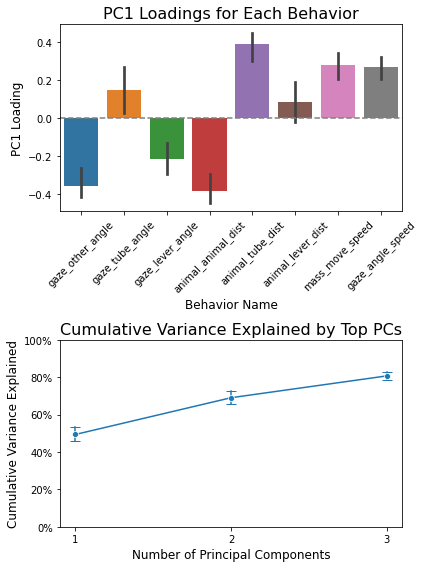

In [63]:
# animal_to_ana = 'dodson'
animal_to_ana = 'kanga'

#
# conditions_to_ana = np.unique(task_conditions)
# conditions_to_ana = ['MC',]
# conditions_to_ana = ['SR']
# conditions_to_ana = ['MC_DannonAuto']
#
# for Kanga only
conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho',]
# conditions_to_ana = ['MC', 'MC_DannonAuto', 'MC_KangaAuto', 'MC_withDodson','MC_withGinger', 
#                      'MC_withKoala', 'MC_withVermelho', 'NV', ]
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 
#                      'MC_withKoala', 'MC_withVermelho', 'SR', 'SR_withDodson' ]
# 
# for dodson only
# conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala',  ]
# conditions_to_ana = ['MC', 'MC_DodsonAuto_withKoala', 'MC_KoalaAuto_withKoala',
#                      'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala',  ]
# conditions_to_ana = ['MC', 'MC_DodsonAuto_withKoala', 'MC_KoalaAuto_withKoala',
#                       'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala',  ]
#
# conditions_to_ana = ['MC', 
#               'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 'SR', 'SR_withGingerNew', 'SR_withKanga',
#              'SR_withKoala',  ]

condition_name = 'allMC'

vars_toPCA_names = ['gaze_other_angle', 'gaze_tube_angle', 'gaze_lever_angle', 'animal_animal_dist',
                    'animal_tube_dist', 'animal_lever_dist', 'mass_move_speed', 'gaze_angle_speed',]

bhvtoPC1_loadings_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal',])
bhvPC123explained_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal',])

#
for idate in np.arange(0,ndates,1):
    date_tgt = dates_list[idate]
    task_condition = task_conditions[idate]

    # only analyze the targeted conditions
    if not np.isin(task_condition,conditions_to_ana):
        continue
        
    # remove empty entries
    # Get the specific dictionary for the date
    loadings_dict = bhvtoPC1_loadings_all_dates[date_tgt]
    # Create a new dictionary, keeping only items where the value has a length greater than 0
    filtered_loadings = {key: value for key, value in loadings_dict.items() if len(value) > 0}
    # Update the original structure with the filtered dictionary
    bhvtoPC1_loadings_all_dates[date_tgt] = filtered_loadings
    #
    # Get the specific dictionary for the date
    loadings_dict = bhvPC123explained_all_dates[date_tgt]
    # Create a new dictionary, keeping only items where the value has a length greater than 0
    filtered_loadings = {key: value for key, value in loadings_dict.items() if len(value) > 0}
    # Update the original structure with the filtered dictionary
    bhvPC123explained_all_dates[date_tgt] = filtered_loadings
    
    
    #    
    # pca loading for self animal
    if 0:
        bhvtoPC1_loadings_idate = bhvtoPC1_loadings_all_dates[date_tgt][animal_to_ana]
        bhvPC123explained_idate = bhvPC123explained_all_dates[date_tgt][animal_to_ana]

    # it's more important to look at pca loading for partner animal
    animal_names = list(bhvtoPC1_loadings_all_dates[date_tgt].keys())
    partner_ani_name = animal_names[np.where(~np.isin(animal_names,animal_to_ana))[0][0]]
    if 1:
        bhvtoPC1_loadings_idate = bhvtoPC1_loadings_all_dates[date_tgt][partner_ani_name]
        bhvPC123explained_idate = bhvPC123explained_all_dates[date_tgt][partner_ani_name]

    #
    nvaris = np.shape(vars_toPCA_names)[0]
    for ivari in np.arange(0,nvaris,1):
        bhvtoPC1_loadings_all_dates_df = bhvtoPC1_loadings_all_dates_df.append({'dates': date_tgt, 
                                                                            'condition': task_condition,
                                                                            'act_animal': animal_to_ana,
                                                                            'bhv_name': vars_toPCA_names[ivari],
                                                                            'PC1_loading': bhvtoPC1_loadings_idate[ivari],
                                                                            }, ignore_index=True)
        
    # 
    for iPC in np.arange(0,3,1):
        bhvPC123explained_all_dates_df = bhvPC123explained_all_dates_df.append({'dates': date_tgt, 
                                                                            'condition': task_condition,
                                                                            'act_animal': animal_to_ana,
                                                                            'PCnumber': iPC+1,
                                                                            'PCexplained': bhvPC123explained_idate[iPC],
                                                                            }, ignore_index=True)

#
bhvPC123explained_all_dates_df['cumulative_explained'] = bhvPC123explained_all_dates_df.sort_values('PCnumber') \
                                                                                    .groupby('dates')['PCexplained'] \
                                                                                    .cumsum()
        
# do the plot
import matplotlib.ticker as mtick

# Create a figure with two subplots, arranged vertically (2 rows, 1 column)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(6, 8))
# --- Subplot 1: PC1 Loadings ---
seaborn.barplot(
    data=bhvtoPC1_loadings_all_dates_df,
    x='bhv_name',
    y='PC1_loading',
    order=vars_toPCA_names,
    # palette='viridis',
    ax=ax1  # Specify that this plot goes on the first axis
)
ax1.set_title('PC1 Loadings for Each Behavior', fontsize=16)
ax1.set_xlabel('Behavior Name', fontsize=12)
ax1.set_ylabel('PC1 Loading', fontsize=12)
ax1.axhline(0, color='grey', linestyle='--')
ax1.tick_params(axis='x', labelrotation=45)

# --- Subplot 2: Variance Explained by PC1, PC2, PC3 ---
seaborn.lineplot(
    data=bhvPC123explained_all_dates_df,
    x='PCnumber',
    y='cumulative_explained',
    marker='o',
    err_style="bars",
    errorbar=('ci', 95),
    err_kws={'capsize': 5},  # This is the corrected way to add caps
    ax=ax2
)

# 3. Update titles and labels to reflect the new plot
ax2.set_title('Cumulative Variance Explained by Top PCs', fontsize=16)
ax2.set_xlabel('Number of Principal Components', fontsize=12)
ax2.set_ylabel('Cumulative Variance Explained', fontsize=12)
# Set x-axis ticks to be integers (1, 2, 3)
ax2.set_xticks([1, 2, 3])
# Format the y-axis to show percentages
ax2.yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
ax2.set_ylim(0, 1) # Set y-axis limit from 0% to 100%
# Adjust layout to prevent plots from overlapping
plt.tight_layout()

savefig = 1
if savefig:
    figsavefolder = data_saved_folder + "fig_for_basic_neural_analysis_allsessions_basicEvents_PCA_makeBhvNeuronVideos_PullStartToPull_section_continuousBhv_PCAonBhv/" + \
                    cameraID + "/" + animal1_filenames[0] + "_" + animal2_filenames[0] + "/bhvvariables_PCA_summary_fig/"

    if not os.path.exists(figsavefolder):
        os.makedirs(figsavefolder)

    if 0:
        plt.savefig(figsavefolder + animal_to_ana + '_in_' + condition_name +
                '_bhvvariables_PC123explained_PC1loadings.pdf')
    else:
        plt.savefig(figsavefolder + animal_to_ana + '_partner_in_' + condition_name +
                '_bhvvariables_PC123explained_PC1loadings.pdf')
    

In [48]:
bhvtoPC1_loadings_all_dates[date_tgt]

{'dodson': array([-0.41005064,  0.40134345, -0.15698453, -0.44981192,  0.4999138 ,
         0.29603008,  0.16213453,  0.28279284]),
 'gingerNew': [],
 'ginger': array([-0.42159477,  0.41918282,  0.17854957, -0.42678769,  0.45891646,
         0.41588089, -0.19469522, -0.10511173])}

In [43]:
np.where(np.isin(animal_names,animal_to_ana))[0][0]

0

## Organize the data
### put all the target data together for further analysis
### also organize and save the data for the hddm analysis

In [ ]:

# choose one pull_trig_events type to work with
# options: ['gaze_other_angle','gaze_tube_angle','gaze_lever_angle','animal_animal_dist',
#           'animal_tube_dist','animal_lever_dist','othergaze_self_angle',
#           'mass_move_speed','gaze_angle_speed','otherani_otherlever_dist',
#           'socialgaze_prob','othergaze_prob']
#
# pull_trig_events_tgtname = 'otherani_otherlever_dist' 
pull_trig_events_tgtname = 'socialgaze_prob' # for testing if individual trial different was from gaze start time
# pull_trig_events_tgtname = 'othergaze_prob' # if to test things aligned to partner's pull (in that case, the subject's gaze becomes othergaze) 


# Keep these as additional controls
pull_trig_otherpull_name = 'otherpull_prob'
pull_trig_selfpull_name = 'selfpull_prob'
# pull_trig_selfspeed_name = 'mass_move_speed'
# pull_trig_otherspeed_name = 'other_mass_move_speed'
pull_trig_selfspeed_name = 'self_PC1'
pull_trig_otherspeed_name = 'other_PC1'
pull_time_pre_reward_name = 'time_from_last_reward'
prefail_pull_num_name = 'num_preceding_failpull'
pull_rt_name = 'pull_rt'

#
animal_to_ana = 'dodson'
# animal_to_ana = 'kanga'

#
# conditions_to_ana = np.unique(task_conditions)
# conditions_to_ana = ['MC',]
# conditions_to_ana = ['SR']
# conditions_to_ana = ['MC_DannonAuto']
#
# for Kanga only
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 'MC_withKoala', 'MC_withVermelho',]
# conditions_to_ana = ['MC', 'MC_DannonAuto', 'MC_KangaAuto', 'MC_withDodson','MC_withGinger', 
#                      'MC_withKoala', 'MC_withVermelho', 'NV', ]
# conditions_to_ana = ['MC', 'MC_withDodson','MC_withGinger', 
#                      'MC_withKoala', 'MC_withVermelho', 'SR', 'SR_withDodson' ]
# 
# for dodson only
conditions_to_ana = ['MC', 'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala',  ]
# conditions_to_ana = ['MC', 'MC_DodsonAuto_withKoala', 'MC_KoalaAuto_withKoala',
#                      'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala',  ]
# conditions_to_ana = ['MC', 'MC_DodsonAuto_withKoala', 'MC_KoalaAuto_withKoala',
#                       'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala',  ]
#
# conditions_to_ana = ['MC', 
#               'MC_withGingerNew', 'MC_withKanga', 'MC_withKoala', 'SR', 'SR_withGingerNew', 'SR_withKanga',
#              'SR_withKoala',  ]

condition_name = 'allMC'

bhvevents_aligned_FR_allevents_all_dates_df = pd.DataFrame(columns=['dates','condition','act_animal','bhv_name',
                                                                    'succrate','clusterID',
                                                                    'channelID','FR_ievent'])

try:

    # dummy 
    
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+\
        '/'+cameraID+'/'+animal_to_ana+'/hddm_model_fitted_combinedsession_withNeurons/'

    with open(data_saved_subfolder+'/hddm_RawFullDatas_flexibleTW_newRTdefinition_'+doOnsetAfterMin_suffix+'withFRs_all_dates_'+\
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'rb') as f:
        bhvevents_aligned_FR_allevents_all_dates_df = pickle.load(f)

except:
    for idate in np.arange(0,ndates,1):
        date_tgt = dates_list[idate]
        task_condition = task_conditions[idate]
        
        # only analyze the targeted conditions
        if not np.isin(task_condition,conditions_to_ana):
            continue
    
        succrate = succ_rate_all_dates[idate]
        
        bhv_types = list(bhvevents_pullstartTopull_aligned_FR_allevents_all_dates[date_tgt].keys())
    
        for ibhv_type in bhv_types:
    
            clusterIDs = list(bhvevents_pullstartTopull_aligned_FR_allevents_all_dates[date_tgt][ibhv_type].keys())
    
            ibhv_type_split = ibhv_type.split()
            if np.shape(ibhv_type_split)[0]==3:
                ibhv_type_split[1] = ibhv_type_split[1]+'_'+ibhv_type_split[2]
    
            # only analyze targeted action animal
            if not np.isin(ibhv_type_split[0], animal_to_ana):
                continue
            
            
            # load the pull_trig_continuous_events
            try:
                pull_trig_events_tgt = pullstartTopull_trig_events_all_dates[date_tgt][(ibhv_type_split[0],pull_trig_events_tgtname)]
                pull_trig_otherpull = pullstartTopull_trig_events_all_dates[date_tgt][(ibhv_type_split[0],pull_trig_otherpull_name)]
                pull_trig_selfpull = pullstartTopull_trig_events_all_dates[date_tgt][(ibhv_type_split[0],pull_trig_selfpull_name)]
                pull_trig_selfspeed = pullstartTopull_trig_events_all_dates[date_tgt][(ibhv_type_split[0],pull_trig_selfspeed_name)]
                pull_trig_otherspeed = pullstartTopull_trig_events_all_dates[date_tgt][(ibhv_type_split[0],pull_trig_otherspeed_name)]
                #
                pull_trig_prerewardtime = np.array(list(pull_infos_all_dates[date_tgt][(ibhv_type_split[0],pull_time_pre_reward_name)]))
                prefail_pull_num = np.array(list(pull_infos_all_dates[date_tgt][(ibhv_type_split[0],prefail_pull_num_name)]))
                #
                pull_rt = np.array(list(pull_rts_all_dates[date_tgt][ibhv_type_split[0]]))
                #
                pull_outcome = np.hstack([1-(prefail_pull_num[1:]>0).astype(int),np.nan])
            except:
                pull_trig_events_tgt = np.nan
                pull_trig_otherpull = np.nan
                pull_trig_selfpull = np.nan
                pull_trig_selfspeed = np.nan
                pull_trig_otherspeed = np.nan
                #
                pull_trig_prerewardtime = np.nan
                prefail_pull_num = np.nan
                pull_rt = np.nan
            
                
            for iclusterID in clusterIDs:   
    
                ichannelID = bhvevents_pullstartTopull_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['ch']
                iFR_allevents = bhvevents_pullstartTopull_aligned_FR_allevents_all_dates[date_tgt][ibhv_type][iclusterID]['FR_allevents']
    
                #
                nevents = np.shape([len(x) for x in pull_trig_events_tgt])[0]
                
                for ievent in np.arange(0,nevents,1):
                
                    bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df.append({'dates': date_tgt, 
                                                                                        'condition':task_condition,
                                                                                        'act_animal':ibhv_type_split[0],
                                                                                        'bhv_name': ibhv_type_split[1],
                                                                                        'bhv_id':ievent,
                                                                                        'succrate':succrate[0],
                                                                                        'clusterID':iclusterID,
                                                                                        'channelID':ichannelID,
                                                                                        'FR_ievent':iFR_allevents[ievent],
                                                                                         pull_trig_events_tgtname:pull_trig_events_tgt[ievent],                          
                                                                                         pull_trig_otherpull_name:pull_trig_otherpull[ievent],                          
                                                                                         pull_trig_selfpull_name:pull_trig_selfpull[ievent],
                                                                                         pull_trig_otherspeed_name:pull_trig_otherspeed[ievent],                          
                                                                                         pull_trig_selfspeed_name:pull_trig_selfspeed[ievent],
                                                                                                                      
                                                                                         pull_time_pre_reward_name:pull_trig_prerewardtime[ievent],
                                                                                         prefail_pull_num_name:prefail_pull_num[ievent],
                                                                                         pull_rt_name:pull_rt[ievent],
                                                                                                                      
                                                                                         'pull_outcome': pull_outcome[ievent],
                                                                                        }, ignore_index=True)
    
    
    # save the data with other HDDM dataframes for the modeling
    savedata = 1
    
    if savedata:
        data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+\
            '/'+cameraID+'/'+animal_to_ana+'/hddm_model_fitted_combinedsession_withNeurons/'
        if not os.path.exists(data_saved_subfolder):
                os.makedirs(data_saved_subfolder)
    
        with open(data_saved_subfolder+'/hddm_RawFullDatas_flexibleTW_newRTdefinition_'+doOnsetAfterMin_suffix+'withFRs_all_dates_'+\
                  animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
            pickle.dump(bhvevents_aligned_FR_allevents_all_dates_df, f) 

           
                

In [ ]:
# save the original dataframe for reference 
bhvevents_aligned_FR_allevents_all_dates_df_origin = bhvevents_aligned_FR_allevents_all_dates_df.copy()


In [ ]:
bhvevents_aligned_FR_allevents_all_dates_df.keys()

In [ ]:
# bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df_origin


In [ ]:
# add some new columns
bhvevents_aligned_FR_allevents_all_dates_df['previous_pull_outcome'] = (
        bhvevents_aligned_FR_allevents_all_dates_df['num_preceding_failpull'] == 0
    ).astype(int)

# Compute AUC for social gaze probability
# bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_auc'] = bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_prob'].apply(
#     lambda x: np.trapz(x) if isinstance(x, (list, np.ndarray)) else np.nan
# )
bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_auc'] = bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_prob'].apply(
    lambda x: np.nansum(x) if isinstance(x, (list, np.ndarray)) else np.nan
)
# bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_auc'] = \
# bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_auc']/bhvevents_aligned_FR_allevents_all_dates_df['pull_rt']

# Mean and STD for mass_move_speed
bhvevents_aligned_FR_allevents_all_dates_df['self_PC1_mean'] = bhvevents_aligned_FR_allevents_all_dates_df['self_PC1'].apply(
    lambda x: np.nanmean(x) if isinstance(x, (list, np.ndarray)) else np.nan
)
bhvevents_aligned_FR_allevents_all_dates_df['self_PC1_std'] = bhvevents_aligned_FR_allevents_all_dates_df['self_PC1'].apply(
    lambda x: np.nanstd(x) if isinstance(x, (list, np.ndarray)) else np.nan
)

# Mean and STD for other_mass_move_speed
bhvevents_aligned_FR_allevents_all_dates_df['other_PC1_mean'] = bhvevents_aligned_FR_allevents_all_dates_df['other_PC1'].apply(
    lambda x: np.nanmean(x) if isinstance(x, (list, np.ndarray)) else np.nan
)
bhvevents_aligned_FR_allevents_all_dates_df['other_PC1_std'] = bhvevents_aligned_FR_allevents_all_dates_df['other_PC1'].apply(
    lambda x: np.nanstd(x) if isinstance(x, (list, np.ndarray)) else np.nan
)

# firing rate mean and slope before pull (0.85s before)
from scipy.stats import linregress
from tqdm import tqdm

#
# Compute mean firing rate
bhvevents_aligned_FR_allevents_all_dates_df['fr_mean'] = bhvevents_aligned_FR_allevents_all_dates_df['FR_ievent'].apply(
    lambda x: np.nanmean(x) if isinstance(x, (list, np.ndarray)) else np.nan
)

# 
# Compute the slope, in two ways
#
# Make a clean copy to avoid SettingWithCopyWarning
df = bhvevents_aligned_FR_allevents_all_dates_df.copy()

# === Fixed slope before 0.85s from pull ===
pull_margin_frames = int(0.85 * fps)

def compute_fr_slope(fr_trace):
    if isinstance(fr_trace, (list, np.ndarray)) and len(fr_trace) > pull_margin_frames:
        y = fr_trace[:len(fr_trace) - pull_margin_frames]
        x = np.arange(len(y))
        try:
            slope, *_ = linregress(x, y)
            return abs(slope)
        except:
            return np.nan
    return np.nan

df.loc[:, 'fr_slope'] = df['FR_ievent'].apply(compute_fr_slope)

# === Peak-based slope calculation: use shortest trial ===

# Prepare new columns for slopes and peak times
df['fr_slope_peakbased'] = np.nan
df['fr_peak_time'] = np.nan

# Group by neuron
grouped = df.groupby(['dates', 'clusterID'])

for (date, cluster_id), group in tqdm(grouped, desc="Processing neurons"):

    traces = group['FR_ievent'].dropna().tolist()
    if len(traces) < 2:
        continue

    # Align traces by pull (end), pad shorter trials with nan at the front
    min_len = min(len(trace) for trace in traces)
    aligned = [trace[-min_len:] if len(trace) >= min_len else
               np.pad(trace, (min_len - len(trace), 0), constant_values=np.nan)
               for trace in traces]

    stacked = np.stack(aligned)  # shape: (n_trials, min_len)
    mean_trace = np.nanmean(stacked, axis=0)

    # Compute slope of mean trace (full)
    x_full = np.arange(min_len)
    slope_full = linregress(x_full, mean_trace).slope

    # Find peak index based on slope sign
    if slope_full >= 0:
        peak_idx = np.nanargmax(mean_trace)
    else:
        peak_idx = np.nanargmin(mean_trace)

    # Convert peak index to peak time relative to pull (end-aligned)
    peak_time = (peak_idx - (min_len - 1)) / fps

    # Save peak_time for all trials of this neuron
    df.loc[(df['dates'] == date) & (df['clusterID'] == cluster_id), 'fr_peak_time'] = peak_time

    # For each trial, calculate slope from trial start to the peak index (if peak_idx within trial length)
    for idx, row in group.iterrows():
        fr_trace = row['FR_ievent']
        trial_len = len(fr_trace)
        
        # Align trial trace to end, pad front if needed
        if trial_len < min_len:
            padded_trace = np.pad(fr_trace, (min_len - trial_len, 0), constant_values=np.nan)
        else:
            padded_trace = fr_trace[-min_len:]

        # Make sure peak_idx is within trial length
        if peak_idx < len(padded_trace):
            y = padded_trace[:peak_idx+1]
            x = np.arange(len(y))
            if np.isnan(y).all() or len(y) < 2:
                slope = np.nan
            else:
                slope = linregress(x, y).slope
            # Optional: store absolute slope if you want
            slope = abs(slope) if not np.isnan(slope) else np.nan

            df.loc[idx, 'fr_slope_peakbased'] = slope
        else:
            df.loc[idx, 'fr_slope_peakbased'] = np.nan

# Save back to original dataframe
bhvevents_aligned_FR_allevents_all_dates_df['fr_slope_peakbased'] = df['fr_slope_peakbased']
bhvevents_aligned_FR_allevents_all_dates_df['fr_peak_time'] = df['fr_peak_time']
bhvevents_aligned_FR_allevents_all_dates_df['fr_slope'] = df['fr_slope']

In [ ]:
xxx = bhvevents_aligned_FR_allevents_all_dates_df['fr_slope']
yyy = bhvevents_aligned_FR_allevents_all_dates_df['fr_slope_peakbased']
# plt.plot(xxx,yyy,'.')

In [ ]:
##########
# organize the data in order to do HDDM - average across neurons for the unique trial
##########

# Step 1: Group by unique trial (date, bhv_id) and average the FR_ievent across neurons
averaged_df = bhvevents_aligned_FR_allevents_all_dates_df.groupby(['dates', 'bhv_id'])['FR_ievent'].apply(
    lambda traces: np.mean(np.stack(traces.to_numpy()), axis=0)
).reset_index()

# Step 2: Rename the averaged firing rate column
averaged_df = averaged_df.rename(columns={'FR_ievent': 'FR_ievent_avg'})

# Step 3: Select representative behavioral columns to merge back (drop duplicates so one per trial)
representative_cols = [
        'dates', 'condition', 'act_animal', 'bhv_name', 'succrate', 'bhv_id', 
        # 'mass_move_speed','other_mass_move_speed',
        'self_PC1','other_PC1',
        'num_preceding_failpull',  'otherpull_prob',
        'pull_rt', 'selfpull_prob', 'socialgaze_prob', 'time_from_last_reward',
        'previous_pull_outcome', 'pull_outcome', 'socialgaze_auc', 
        'self_PC1_mean',
        'self_PC1_std', 
        'other_PC1_mean',
        'other_PC1_std',
        # 'mass_move_speed_mean',
        # 'mass_move_speed_std', 
        # 'other_mass_move_speed_mean',
        # 'other_mass_move_speed_std',
]

# Get one row per (dates, bhv_id) combination
behavior_df = bhvevents_aligned_FR_allevents_all_dates_df.drop_duplicates(subset=['dates', 'bhv_id'])[representative_cols]

# Step 4: Merge firing rate and behavioral data
bhvevents_aligned_FR_allevents_alldates_mergedneurons_df = pd.merge(averaged_df, behavior_df, 
                                                                    on=['dates', 'bhv_id'], how='left')

# Step 5
# Compute mean firing rate
bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['fr_mean'] = \
      bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['FR_ievent_avg'].apply(
    lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else np.nan
)

# Compute slope of firing rate before 0.85s prior to pull
def compute_fr_slope(fr_trace):
    if isinstance(fr_trace, (list, np.ndarray)) and len(fr_trace) > pull_margin_frames:
        y = fr_trace[:len(fr_trace) - pull_margin_frames]
        x = np.arange(len(y))
        slope, _, _, _, _ = linregress(x, y)
        #
        if slope<0:
            slope = -slope
        
        return slope
    return np.nan

bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['fr_slope'] = \
     bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['FR_ievent_avg'].apply(compute_fr_slope)


# save the data with other HDDM dataframes for the modeling
savedata = 1

if savedata:
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+\
        '/'+cameraID+'/'+animal_to_ana+'/hddm_model_fitted_combinedsession_withNeurons/'
    if not os.path.exists(data_saved_subfolder):
            os.makedirs(data_saved_subfolder)

    with open(data_saved_subfolder+'/hddm_datas_flexibleTW_newRTdefinition_'+doOnsetAfterMin_suffix+'withFRs_all_dates_'+
              animal1_fixedorders[0]+animal2_fixedorders[0]+'.pkl', 'wb') as f:
        pickle.dump(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df, f) 


In [ ]:
bhvevents_aligned_FR_allevents_alldates_mergedneurons_df

In [ ]:
##########
# load the HDDM data to get the drift diffusion v for further correlation
##########

if 1:
    
    data_saved_subfolder = data_saved_folder+'data_saved_singlecam_wholebody_neural_and_hddm'+savefile_sufix+\
        '/'+cameraID+'/'+animal_to_ana+'/hddm_model_fitted_combinedsession_withNeurons/'

    with open(data_saved_subfolder+'/hddm_model_fitted_traces_'+condition_name+doOnsetAfterMin_suffix+'.pkl', 'rb') as f:
        hddm_model_fitted_traces = pickle.load(f)
    with open(data_saved_subfolder+'/hddm_model_fitted_stats_'+condition_name+doOnsetAfterMin_suffix+'.pkl', 'rb') as f:
        hddm_model_fitted_stats = pickle.load(f)
    with open(data_saved_subfolder+'/hddm_model_fitted_nogaze_traces_'+condition_name+doOnsetAfterMin_suffix+'.pkl', 'rb') as f:
        hddm_model_fitted_nogaze_traces = pickle.load(f)
    with open(data_saved_subfolder+'/hddm_model_fitted_nogaze_stats_'+condition_name+doOnsetAfterMin_suffix+'.pkl', 'rb') as f:
        hddm_model_fitted_nogaze_stats = pickle.load(f)
    
    v_inter = hddm_model_fitted_stats['mean']['v_Intercept']
    v_self_gaze_auc = hddm_model_fitted_stats['mean']['v_self_gaze_auc']
    v_partner_mean_speed = hddm_model_fitted_stats['mean']['v_partner_mean_speed']
    v_self_mean_speed = hddm_model_fitted_stats['mean']['v_self_mean_speed']
    v_partner_speed_std = hddm_model_fitted_stats['mean']['v_partner_speed_std']
    v_self_speed_std = hddm_model_fitted_stats['mean']['v_self_speed_std']

    #
    bhvevents_aligned_FR_allevents_all_dates_df['predicted_v'] = v_inter + \
            bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_auc'] * v_self_gaze_auc + \
            bhvevents_aligned_FR_allevents_all_dates_df['other_mass_move_speed_mean'] * v_partner_mean_speed + \
            bhvevents_aligned_FR_allevents_all_dates_df['other_mass_move_speed_std'] * v_partner_speed_std + \
            bhvevents_aligned_FR_allevents_all_dates_df['mass_move_speed_mean'] * v_self_mean_speed + \
            bhvevents_aligned_FR_allevents_all_dates_df['mass_move_speed_std'] * v_self_speed_std 

    #
    bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['predicted_v'] = v_inter + \
            bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['socialgaze_auc'] * v_self_gaze_auc + \
            bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['other_mass_move_speed_mean'] * v_partner_mean_speed + \
            bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['other_mass_move_speed_std'] * v_partner_speed_std + \
            bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['mass_move_speed_mean'] * v_self_mean_speed + \
            bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['mass_move_speed_std'] * v_self_speed_std 




In [ ]:
# add some criteria to remove trials
# bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df[\
#                                 bhvevents_aligned_FR_allevents_all_dates_df['previous_pull_outcome']==1]

# bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df[\
#                                 bhvevents_aligned_FR_allevents_all_dates_df['pull_rt']>3]
# bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df[\
#                                 bhvevents_aligned_FR_allevents_all_dates_df['pull_rt']<20]

# Remove outlier pull_rt values
# method 1
if 0:
    # Compute IQR bounds
    bhv_unique_df = bhvevents_aligned_FR_allevents_all_dates_df.drop_duplicates(subset=['dates', 'bhv_id'])
    #
    q1 = bhv_unique_df['pull_rt'].quantile(0.25)
    q3 = bhv_unique_df['pull_rt'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    #
    # Filter out outliers
    bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df[
        (bhvevents_aligned_FR_allevents_all_dates_df['pull_rt'] >= lower_bound) &
        (bhvevents_aligned_FR_allevents_all_dates_df['pull_rt'] <= upper_bound)
    ]
# method 2    
if 1:
    # Symmetrical trimming: keep central 90% of pull_rt
    bhv_unique_df = bhvevents_aligned_FR_allevents_all_dates_df.drop_duplicates(subset=['dates', 'bhv_id'])
    #
    lower_bound = bhv_unique_df['pull_rt'].quantile(0.05)
    # lower_bound = 4
    upper_bound = bhv_unique_df['pull_rt'].quantile(0.95)

    # Filter the dataframe
    bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df[
        (bhvevents_aligned_FR_allevents_all_dates_df['pull_rt'] >= lower_bound) &
        (bhvevents_aligned_FR_allevents_all_dates_df['pull_rt'] <= upper_bound)
    ]
    
print(lower_bound)
print(upper_bound)

In [ ]:
# only look at the successful pull
if 0:
    ind_ = bhvevents_aligned_FR_allevents_all_dates_df['pull_outcome']==1
    bhvevents_aligned_FR_allevents_all_dates_df = bhvevents_aligned_FR_allevents_all_dates_df[ind_]

In [ ]:
xxx = bhvevents_aligned_FR_allevents_all_dates_df['pull_rt']
yyy = bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_auc']
plt.plot(xxx,yyy,'.')
st.pearsonr(xxx,yyy)

In [ ]:
bhvevents_aligned_FR_allevents_all_dates_df.keys()

In [ ]:
# bhvevents_aligned_FR_allevents_all_dates_df
print(np.sum(bhvevents_aligned_FR_allevents_all_dates_df['pull_outcome']))
print(np.shape(bhvevents_aligned_FR_allevents_all_dates_df['pull_outcome'])[0])

In [ ]:
# do the same clearup for the merged dataframe
# Remove outlier pull_rt values
# method 1
if 0:
    # Compute IQR bounds
    bhv_unique_df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.drop_duplicates(subset=['dates', 'bhv_id'])
    #
    q1 = bhv_unique_df['pull_rt'].quantile(0.25)
    q3 = bhv_unique_df['pull_rt'].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 1.5 * iqr
    upper_bound = q3 + 1.5 * iqr
    #
    # Filter out outliers
    bhvevents_aligned_FR_allevents_alldates_mergedneurons_df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df[
        (bhvevents_aligned_FR_allevents_all_dates_df['pull_rt'] >= lower_bound) &
        (bhvevents_aligned_FR_allevents_all_dates_df['pull_rt'] <= upper_bound)
    ]
# method 2    
if 1:
    # Symmetrical trimming: keep central 90% of pull_rt
    bhv_unique_df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.drop_duplicates(subset=['dates', 'bhv_id'])
    #
    lower_bound = bhv_unique_df['pull_rt'].quantile(0.05)
    # lower_bound = 4
    upper_bound = bhv_unique_df['pull_rt'].quantile(0.95)

    # Filter the dataframe
    bhvevents_aligned_FR_allevents_alldates_mergedneurons_df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df[
        (bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['pull_rt'] >= lower_bound) &
        (bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['pull_rt'] <= upper_bound)
    ]
    
print(lower_bound)
print(upper_bound)

In [ ]:
# only look at the successful pull
if 1:
    ind_ = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['pull_outcome']==1
    bhvevents_aligned_FR_allevents_alldates_mergedneurons_df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df[ind_]

In [ ]:
ind_ = 1749
if 0:
    plt.plot(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['FR_ievent_avg'].loc[ind_])
    plt.plot(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['mass_move_speed'].loc[ind_]/800)
    plt.plot(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['other_mass_move_speed'].loc[ind_]/800)
    plt.plot(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df['socialgaze_prob'].loc[ind_]*5)
if 0:
    plt.plot(bhvevents_aligned_FR_allevents_all_dates_df['FR_ievent'].loc[ind_])
    plt.plot(bhvevents_aligned_FR_allevents_all_dates_df['mass_move_speed'].loc[ind_]/800)
    plt.plot(bhvevents_aligned_FR_allevents_all_dates_df['other_mass_move_speed'].loc[ind_]/800)
    plt.plot(bhvevents_aligned_FR_allevents_all_dates_df['socialgaze_prob'].loc[ind_]*5)


#### trial wise correlation between FR trace and other continuous variables

In [ ]:
if 0:
    from sklearn.linear_model import LinearRegression
    from sklearn.preprocessing import StandardScaler
    from scipy.stats import f_oneway, ttest_rel
    import itertools
    import seaborn as sns
    
    nentries = len(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df)
    df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.copy()
    
    # ---------- Step 2: Regression calculations ----------
    r2_uni = {var: [] for var in ['mass', 'partner', 'selfpull', 'socialgaze']}
    r2_full = []
    delta_r2 = {var: [] for var in ['mass', 'partner', 'selfpull', 'socialgaze']}
    betas = {var: [] for var in ['mass', 'partner', 'selfpull', 'socialgaze']}
    
    for i in range(len(df)):
        y = df.iloc[i]['FR_ievent_avg']
        X_vars = {
            'mass': df.iloc[i]['self_PC1'],
            'partner': df.iloc[i]['other_PC1'],
            'selfpull': df.iloc[i]['selfpull_prob'],
            'socialgaze': df.iloc[i]['socialgaze_prob']
        }
    
        if any(len(y) != len(x) for x in X_vars.values()):
            continue
    
        try:
            # Univariate regressions
            for varname, x in X_vars.items():
                model_uni = LinearRegression().fit(np.array(x).reshape(-1, 1), y)
                r2_uni[varname].append(model_uni.score(np.array(x).reshape(-1, 1), y))
            
            # Full multivariate regression
            X_full = np.vstack([X_vars[v] for v in ['mass', 'partner', 'selfpull', 'socialgaze']]).T
            X_std = StandardScaler().fit_transform(X_full)
            y_std = (y - np.mean(y)) / np.std(y)
            model_full = LinearRegression().fit(X_std, y_std)
            r2_full_val = model_full.score(X_std, y_std)
            r2_full.append(r2_full_val)
    
            for idx, var in enumerate(['mass', 'partner', 'selfpull', 'socialgaze']):
                betas[var].append(model_full.coef_[idx])
    
            # Leave-one-out regressions
            for idx, var in enumerate(['mass', 'partner', 'selfpull', 'socialgaze']):
                X_reduced = np.delete(X_full, idx, axis=1)
                X_reduced_std = StandardScaler().fit_transform(X_reduced)
                model_reduced = LinearRegression().fit(X_reduced_std, y_std)
                r2_reduced = model_reduced.score(X_reduced_std, y_std)
                delta_r2[var].append(r2_full_val - r2_reduced)
    
        except:
            continue
    
    # ---------- Step 3: Format for plotting ----------
    df_r2_uni = pd.DataFrame([
        {'Variable': var, 'R2': r2} for var, values in r2_uni.items() for r2 in values
    ])
    
    df_delta_r2 = pd.DataFrame([
        {'Variable': var, 'Delta_R2': delta} for var, values in delta_r2.items() for delta in values
    ])
    
    df_betas = pd.DataFrame([
        {'Variable': var, 'Beta': beta} for var, values in betas.items() for beta in values
    ])
    
    # ---------- Step 4: Statistical tests ----------
    anova_r2 = f_oneway(*[df_r2_uni[df_r2_uni['Variable'] == v]['R2'] for v in df_r2_uni['Variable'].unique()])
    anova_delta = f_oneway(*[df_delta_r2[df_delta_r2['Variable'] == v]['Delta_R2'] for v in df_delta_r2['Variable'].unique()])
    anova_beta = f_oneway(*[df_betas[df_betas['Variable'] == v]['Beta'] for v in df_betas['Variable'].unique()])
    
    pairwise_results = []
    variables = ['mass', 'partner', 'selfpull', 'socialgaze']
    for v1, v2 in itertools.combinations(variables, 2):
        x = df_delta_r2[df_delta_r2['Variable'] == v1]['Delta_R2'].dropna()
        y = df_delta_r2[df_delta_r2['Variable'] == v2]['Delta_R2'].dropna()
        min_len = min(len(x), len(y))
        t_stat, p_val = ttest_rel(x[:min_len], y[:min_len])
        pairwise_results.append({'Var1': v1, 'Var2': v2, 'T-stat': t_stat, 'P-value': p_val})
    pairwise_df = pd.DataFrame(pairwise_results)
    
    # ---------- Step 5: Plotting ----------
    fig, axes = plt.subplots(1, 3, figsize=(16, 5))
    
    sns.violinplot(data=df_r2_uni, x='Variable', y='R2', inner='box', ax=axes[0])
    axes[0].set_title('Univariate R² per Variable')
    
    sns.violinplot(data=df_delta_r2, x='Variable', y='Delta_R2',  inner='box', ax=axes[1])
    axes[1].set_title('ΔR² (Unique Contribution) per Variable')
    
    sns.violinplot(data=df_betas, x='Variable', y='Beta', inner='box', ax=axes[2])
    axes[2].set_title('Standardized Beta Coefficients')
    
    plt.tight_layout()
    # plt.savefig("regression_violin_plots.png")
    plt.show()
    
    # ---------- Optional: Print stats ----------
    print("ANOVA R²:", anova_r2)
    print("ANOVA ΔR²:", anova_delta)
    print("ANOVA Betas:", anova_beta)
    print("Pairwise ΔR² comparisons:\n", pairwise_df)

In [ ]:
if 0:
    # test if the mean FR across neurons in each trial is just tracking the self movement, 
    # or after considering the confound of self movement, it still encode social gaze
    
    # nentries = len(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df)
    # df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.copy()
    
    nentries = len(bhvevents_aligned_FR_allevents_all_dates_df)
    df = bhvevents_aligned_FR_allevents_all_dates_df.copy()
    
    # ---------- Step 2: Regression calculations ----------
    r2_uni = {var: [] for var in ['mass', 'socialgaze']}
    r2_full = []
    delta_r2 = {var: [] for var in ['mass', 'socialgaze']}
    betas = {var: [] for var in ['mass',  'socialgaze']}
    
    for i in range(len(df)):
        # y = df.iloc[i]['FR_ievent_avg']
        y = df.iloc[i]['FR_ievent']
        X_vars = {
            'mass': df.iloc[i]['self_PC1'],
            'socialgaze': df.iloc[i]['socialgaze_prob']
        }
        
        try:
            # Full multivariate regression
            X_full = np.vstack([X_vars[v] for v in ['mass', 'socialgaze']]).T
            X_std = StandardScaler().fit_transform(X_full)
            y_std = (y - np.mean(y)) / np.std(y)
            model_full = LinearRegression().fit(X_std, y_std)
            r2_full_val = model_full.score(X_std, y_std)
            r2_full.append(r2_full_val)
        
            for idx, var in enumerate(['mass', 'socialgaze']):
                betas[var].append(model_full.coef_[idx])
    
        except:
            continue
        

In [ ]:
if 0:
    # test if the social gaze prob in each trial is just tracking the self movement, 
    # or after considering the confound of self movement, it still encode parnter movement
    
    nentries = len(bhvevents_aligned_FR_allevents_alldates_mergedneurons_df)
    df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.copy()
    

    # ---------- Step 2: Regression calculations ----------
    r2_uni = {var: [] for var in ['mass', 'partner']}
    r2_full = []
    delta_r2 = {var: [] for var in ['mass', 'partner']}
    betas = {var: [] for var in ['mass',  'partner']}
    
    for i in range(len(df)):
        y = df.iloc[i]['socialgaze_prob']
        X_vars = {
            'mass': df.iloc[i]['self_PC1'],
            'partner': df.iloc[i]['other_PC1']
        }
        
        try:
            # Full multivariate regression
            X_full = np.vstack([X_vars[v] for v in ['mass', 'partner']]).T
            X_std = StandardScaler().fit_transform(X_full)
            y_std = (y - np.mean(y)) / np.std(y)
            model_full = LinearRegression().fit(X_std, y_std)
            r2_full_val = model_full.score(X_std, y_std)
            r2_full.append(r2_full_val)
        
            for idx, var in enumerate(['mass', 'partner']):
                betas[var].append(model_full.coef_[idx])
    
        except:
            continue
        

### Use multi-variable regression to define and label neurons that encode socialgaze, even after control the self movement

In [ ]:
import warnings
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from scipy.stats import f_oneway, ttest_rel
import itertools
import statsmodels.api as sm


warnings.filterwarnings("ignore", category=FutureWarning)

#
dates_toana = np.unique(bhvevents_aligned_FR_allevents_all_dates_df['dates'])
ndates_toana = np.shape(dates_toana)[0]

neuronEncodeSocialGaze_summary_df = pd.DataFrame(columns=['date','clusterID','neuronEncodeSocialGaze'])

for idate in np.arange(0, ndates_toana,1):
    date_toana = dates_toana[idate]

    ind_idate = np.isin(bhvevents_aligned_FR_allevents_all_dates_df['dates'],date_toana)

    df_allneurons_tgt = bhvevents_aligned_FR_allevents_all_dates_df[ind_idate]

    neurons_toana = np.unique(df_allneurons_tgt['clusterID'])
    nneurons_toana = np.shape(neurons_toana)[0]

    for ineuron in np.arange(0,nneurons_toana,1):
        neuron_toana = neurons_toana[ineuron]

        ind_ineuron = np.isin(df_allneurons_tgt['clusterID'],neuron_toana)

        df_ineuron_tgt = df_allneurons_tgt[ind_ineuron]

        # get the FR traces
        FR_allevents = np.array(df_ineuron_tgt['FR_ievent'])
        nFR_allevents = np.shape(FR_allevents)[0]

        # get the socialgaze and self movement traces
        selfspeed_allevents = np.array(df_ineuron_tgt['self_PC1'])
        socialgaze_allevents = np.array(df_ineuron_tgt['socialgaze_prob'])
        nbhv_allevents = np.shape(selfspeed_allevents)[0]

        # make sure the fr and bhv traces has the same size
        if nFR_allevents < nbhv_allevents:
            selfspeed_allevents = selfspeed_allevents[0:nFR_allevents]
            socialgaze_allevents = socialgaze_allevents[0:nFR_allevents]
            nevents = nFR_allevents
        elif nFR_allevents > nbhv_allevents:
            FR_allevents = FR_allevents[0:nbhv_allevents]
            nevents = nbhv_allevents
        else:
            nevents = nFR_allevents

        # remove trial that does not match
        for ievent in np.arange(0,nevents,1):
            ntimepoint_FR = np.shape(FR_allevents[ievent])[0]
            ntimepoint_speed = np.shape(selfspeed_allevents[ievent])[0]
            ntimepoint_gaze = np.shape(socialgaze_allevents[ievent])[0]
            
            if (ntimepoint_speed != ntimepoint_FR) |\
               (ntimepoint_gaze != ntimepoint_FR) |\
               (ntimepoint_gaze != ntimepoint_speed):
                FR_allevents[ievent] = []
                selfspeed_allevents[ievent] = []
                socialgaze_allevents[ievent] = []
        
        # conbine all trials
        FR_allevents_flat = np.concatenate(FR_allevents)
        selfspeed_allevents_flat = np.concatenate(selfspeed_allevents)
        socialgaze_allevents_flat = np.concatenate(socialgaze_allevents)
        #
        min_len = np.min([len(FR_allevents_flat),
                          len(selfspeed_allevents_flat),
                          len(socialgaze_allevents_flat)])
        FR_allevents_flat = FR_allevents_flat[0:min_len]
        selfspeed_allevents_flat = selfspeed_allevents_flat[0:min_len]
        socialgaze_allevents_flat = socialgaze_allevents_flat[0:min_len]
        
        # multi variable regression
        y = FR_allevents_flat
        X_vars = {
            'mass': selfspeed_allevents_flat,
            'socialgaze': socialgaze_allevents_flat
        }

        # Full multivariate regression
        try:
            X_full = np.vstack([X_vars[v] for v in ['mass', 'socialgaze']]).T
            X_std = StandardScaler().fit_transform(X_full)
            y_std = (y - np.mean(y)) / np.std(y)
            # Create a clean DataFrame for statsmodels
            df = pd.DataFrame(X_std, columns=['mass', 'gaze'])
            df['fr'] = y_std # Use the standardized firing rate 
            # Add a constant (intercept) to the predictors
            df = sm.add_constant(df)
            # Fit the Ordinary Least Squares (OLS) model
            model_sm = sm.OLS(df['fr'], df[['const', 'mass', 'gaze']])
            results = model_sm.fit()
    
            if results.pvalues['gaze'] < 0.01:
                neuronEncodeSocialGaze = True
            else:
                neuronEncodeSocialGaze = False
    
            neuronEncodeSocialGaze_summary_df = neuronEncodeSocialGaze_summary_df.append({'date':date_toana,
                                                                                          'clusterID':neuron_toana,
                                                                                          'neuronEncodeSocialGaze':neuronEncodeSocialGaze,
                                                                               }, ignore_index=True)

        except:
            continue

In [ ]:
SocialGazeEncodeNeuronRatio = np.sum(neuronEncodeSocialGaze_summary_df['neuronEncodeSocialGaze'])/\
                              len(neuronEncodeSocialGaze_summary_df['neuronEncodeSocialGaze'])

print('SocialGazeEncodeNeuronRatio: '+str(SocialGazeEncodeNeuronRatio))

In [ ]:
neuronEncodeSocialGaze_summary_df

### correlation among variables - across all trial, without carefully consider mixed effect, for general trend

In [ ]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# Select behavioral and neural variables
columns_of_interest = [
    'pull_rt',
    'num_preceding_failpull',
    'time_from_last_reward',
    'previous_pull_outcome',
    'socialgaze_auc',
    'self_PC1_mean',
    'self_PC1_std',
    'other_PC1_mean',
    'other_PC1_std',
    # 'predicted_v',
    'fr_mean',
    'fr_slope',
    'fr_slope_peakbased',
    # 'fr_peak_time',
]

doSocialGazeEncodeNeuron = 1
#
if doSocialGazeEncodeNeuron:
    goodneuron_df = neuronEncodeSocialGaze_summary_df[neuronEncodeSocialGaze_summary_df['neuronEncodeSocialGaze']]
    #
    df1 = bhvevents_aligned_FR_allevents_all_dates_df.copy()
    df2 = goodneuron_df
    #
    # 1. Rename the 'date' column in the second DataFrame to match the first
    df2_renamed = df2.rename(columns={'date': 'dates'})
    # 2. Perform the inner merge
    # This keeps only the rows from df1 that have a matching ('dates', 'clusterID') pair in df2_renamed
    filtered_df = pd.merge(df1, df2_renamed[['dates', 'clusterID']], on=['dates', 'clusterID'], how='inner')
    #
    # Drop rows with NaN values
    df_clean = filtered_df[columns_of_interest].dropna()

else:
    # Drop rows with NaN values
    df_clean = bhvevents_aligned_FR_allevents_all_dates_df[columns_of_interest].dropna()
    # df_clean = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df[columns_of_interest].dropna()


# Compute correlation and p-values
n = len(columns_of_interest)
corr_matrix = np.zeros((n, n))
pval_matrix = np.ones((n, n))

for i in range(n):
    for j in range(n):
        if i <= j:
            r, p = pearsonr(df_clean[columns_of_interest[i]], df_clean[columns_of_interest[j]])
            corr_matrix[i, j] = corr_matrix[j, i] = r
            pval_matrix[i, j] = pval_matrix[j, i] = p

# FDR correction
pvals_flat = pval_matrix[np.triu_indices(n, k=1)]
_, pvals_corrected, _, _ = multipletests(pvals_flat, method='bonferroni')

# Map corrected p-values back into full matrix
pval_corrected_matrix = np.ones_like(pval_matrix)
pval_corrected_matrix[np.triu_indices(n, k=1)] = pvals_corrected
i_lower = np.tril_indices_from(pval_corrected_matrix, -1)
pval_corrected_matrix[i_lower] = pval_corrected_matrix.T[i_lower]

# Create annotation matrix with stars
annot_matrix = np.empty((n, n), dtype=object)
for i in range(n):
    for j in range(n):
        r = corr_matrix[i, j]
        p = pval_corrected_matrix[i, j]
        annot_matrix[i, j] = f"{r:.2f}{'*' if i != j and p < 0.01 else ''}"

# Plot
plt.figure(figsize=(12, 10))
seaborn.heatmap(corr_matrix, xticklabels=columns_of_interest, yticklabels=columns_of_interest,
            annot=annot_matrix, fmt='', cmap='coolwarm', center=0, square=True,
            cbar_kws={"shrink": 0.8, "label": "Pearson r"})

plt.title('Correlation Matrix with FDR-corrected Significance (p < 0.01)')
plt.tight_layout()
plt.show()

In [ ]:
np.shape(df_clean[columns_of_interest[i]])

### correlation among variables - run each session each neuron separately, the number plotted is the mean correlation coeffient

In [ ]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# Select behavioral and neural variables
columns_of_interest = [
    'pull_rt',
    'num_preceding_failpull',
    'time_from_last_reward',
    'previous_pull_outcome',
    'socialgaze_auc',
    'self_PC1_mean',
    'self_PC1_std',
    'other_PC1_mean',
    'other_PC1_std',
    # 'predicted_v',
    'fr_mean',
    'fr_slope',
    'fr_slope_peakbased',
    # 'fr_peak_time',
]

doSocialGazeEncodeNeuron = 0
#
if doSocialGazeEncodeNeuron:
    goodneuron_df = neuronEncodeSocialGaze_summary_df[neuronEncodeSocialGaze_summary_df['neuronEncodeSocialGaze']]
    #
    df1 = bhvevents_aligned_FR_allevents_all_dates_df.copy()
    df2 = goodneuron_df
    #
    # 1. Rename the 'date' column in the second DataFrame to match the first
    df2_renamed = df2.rename(columns={'date': 'dates'})
    # 2. Perform the inner merge
    # This keeps only the rows from df1 that have a matching ('dates', 'clusterID') pair in df2_renamed
    filtered_df = pd.merge(df1, df2_renamed[['dates', 'clusterID']], on=['dates', 'clusterID'], how='inner')
    #
    # Drop rows with NaN values
    df_clean = filtered_df[columns_of_interest+['dates','clusterID']].dropna()

else:
    # Drop rows with NaN values
    df_clean = bhvevents_aligned_FR_allevents_all_dates_df[columns_of_interest+['dates','clusterID']].dropna()
    # df_clean = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df[columns_of_interest].dropna()


# Compute correlation and p-values
n = len(columns_of_interest)
corr_matrix = np.zeros((n, n))
pval_matrix = np.ones((n, n))

dates_toana = np.unique(df_clean['dates'])
ndates_toana = np.shape(dates_toana)[0]

for i in range(n):
    for j in range(n):
        if i <= j:

            corrs_temp = []
            pvals_temp = []
            
            for idate in np.arange(0,ndates_toana,1):
                
                date_toana = dates_toana[idate]
                
                df_clean_idate = df_clean[np.isin(df_clean['dates'],date_toana)]
            
                neurons_toana = np.unique(df_clean_idate['clusterID'])
                nneurons_toana = np.shape(neurons_toana)[0]
            
                for ineuron in np.arange(0,nneurons_toana,1):
                    neuron_toana = neurons_toana[ineuron]

                    try:
                        df_clean_ineuron = df_clean_idate[np.isin(df_clean_idate['clusterID'],neuron_toana)]
            
                        r, p = pearsonr(df_clean_ineuron[columns_of_interest[i]], df_clean_ineuron[columns_of_interest[j]])
                    
                    except:
                        r = np.nan
                        p = np.nan
                    
                    corrs_temp.append(r)
                    pvals_temp.append(p)

            corr_matrix[i, j] = corr_matrix[j, i] = np.nanmean(np.unique(corrs_temp))
            
            corrs_temp = np.array(corrs_temp)
            corrs_temp = corrs_temp[~np.isnan(corrs_temp)]
            _,pttest = st.ttest_1samp(np.unique(corrs_temp),0)
            pval_matrix[i, j] = pval_matrix[j, i] = pttest


# Create annotation matrix with stars
annot_matrix = np.empty((n, n), dtype=object)
for i in range(n):
    for j in range(n):
        r = corr_matrix[i, j]
        p = pval_matrix[i, j]
        annot_matrix[i, j] = f"{r:.2f}{'*' if i != j and p < 0.01 else ''}"

# Plot
plt.figure(figsize=(12, 10))
seaborn.heatmap(corr_matrix, xticklabels=columns_of_interest, yticklabels=columns_of_interest,
            annot=annot_matrix, fmt='', cmap='coolwarm', center=0, square=True,
            cbar_kws={"shrink": 0.8, "label": "Pearson r"})

plt.title('Correlation Matrix across individual neurons (p < 0.01 means ttest)')
plt.tight_layout()
plt.show()

### correlation among variables - get the information of the corr coef and pvalue of each neuron's fr and bhv variables

In [ ]:
df_clean

### examine the percent of neurons that significantly encode each variables, looking at the FR slope and FR mean separately

In [ ]:
import seaborn as sns
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests
import statsmodels.api as sm

# Variables to correlate with fr_mean and fr_slope
behavior_vars = [
    'pull_rt',
    'num_preceding_failpull',
    'time_from_last_reward',
    'previous_pull_outcome',
    'socialgaze_auc',
    'self_PC1_mean',
    'self_PC1_std',
    'other_PC1_mean',
    'other_PC1_std',
    # 'predicted_v',
]

neural_metrics = ['fr_mean', 'fr_slope']
# neural_metrics = ['fr_mean', 'fr_slope','fr_slope_peakbased']

# Store percent significance for heatmap
results = []

grouped = bhvevents_aligned_FR_allevents_all_dates_df.groupby(['dates', 'clusterID', 'condition'])

for (date, cluster_id, condition), group in grouped:
    for fr_type in neural_metrics:
        df = group[behavior_vars + [fr_type]].dropna()
        if len(df) >= len(behavior_vars) + 2:  # need more trials than predictors
            X = sm.add_constant(df[behavior_vars])
            y = df[fr_type]
            model = sm.OLS(y, X).fit()
            for var in behavior_vars:
                results.append({
                    'date': date,
                    'clusterID': cluster_id,
                    'condition': condition,
                    'fr_metric': fr_type,
                    'predictor': var,
                    'beta': model.params.get(var, np.nan),
                    'pval': model.pvalues.get(var, np.nan),
                    'significant': model.pvalues.get(var, np.nan) < 0.05
                })

regression_results_df = pd.DataFrame(results)

# do the heatmap plotting
# --- Step 1: Compute % of significant neurons per predictor ---
summary = (
    regression_results_df.groupby(['fr_metric', 'predictor'])['significant']
    .mean()
    .unstack(0) * 100  # convert to percentage
)

# --- Step 2: Compute % with any significant beta ---
any_sig_summary = (
    regression_results_df
    .groupby(['fr_metric', 'date', 'clusterID'])['significant']
    .any()
    .groupby(['fr_metric'])
    .mean()
    .to_frame()
    .T * 100  # convert to percentage
)
any_sig_summary.index = ['any_predictor']

# --- Step 3: Combine ---
summary_with_total = pd.concat([summary, any_sig_summary])

# --- Step 4: Round for annotation ---
annot_vals = summary_with_total.round(1).astype(str) + '%'

# --- Step 5: Plot ---
plt.figure(figsize=(10, 7))
sns.heatmap(summary_with_total, annot=annot_vals, fmt='', cmap='YlOrRd',
            cbar_kws={'label': '% of Neurons (p < 0.05)'}, linewidths=0.5)

plt.title('Percent of Neurons Significantly Encoding Each Variable')
plt.ylabel('Behavioral Predictor')
plt.xlabel('Neural Feature')
plt.tight_layout()
plt.show()

In [ ]:
regression_results_df

### correlation among behavioral and neural variables, and this time only consider significant variables

In [ ]:
#
neural_features = ['fr_slope']  # 'fr_mean', 'fr_slope', 'fr_slope_peakbased'
# neural_features = ['fr_mean']
# predictors_to_check = [ 'predicted_v', ] # define which behavioral predictors to check significance for
predictors_to_check =  np.unique(regression_results_df['predictor'])

regression_results_df_totest = regression_results_df.copy()

ind_good = (np.isin(regression_results_df_totest['fr_metric'],neural_features)) &\
           (np.isin(regression_results_df_totest['predictor'],predictors_to_check))
regression_results_df_totest = regression_results_df_totest[ind_good]

sig_neurons = (
    regression_results_df_totest[regression_results_df_totest['significant']]
    .groupby(['date', 'clusterID'])
    .size()
    .reset_index()[['date', 'clusterID']]
)

sig_neuron_keys = set(tuple(x) for x in sig_neurons.to_numpy())

# -----------------------------
# STEP 4: Filter the original DataFrames
# -----------------------------
bhvevents_filtered_df = bhvevents_aligned_FR_allevents_all_dates_df[
    bhvevents_aligned_FR_allevents_all_dates_df[['dates', 'clusterID']].apply(tuple, axis=1).isin(sig_neuron_keys)
].copy()

##########
# organize the data in order to do HDDM - average across neurons for the unique trial
##########

# Step 1: Group by unique trial (date, bhv_id) and average the FR_ievent across neurons
averaged_df = bhvevents_filtered_df.groupby(['dates', 'bhv_id'])['FR_ievent'].apply(
    lambda traces: np.mean(np.stack(traces.to_numpy()), axis=0)
).reset_index()

# Step 2: Rename the averaged firing rate column
averaged_df = averaged_df.rename(columns={'FR_ievent': 'FR_ievent_avg'})

# Step 3: Select representative behavioral columns to merge back (drop duplicates so one per trial)
representative_cols = [
    'dates', 'condition', 'act_animal', 'bhv_name', 'succrate', 'bhv_id', 'self_PC1',
       'num_preceding_failpull', 'other_PC1', 'otherpull_prob',
       'pull_rt', 'pull_outcome', 'selfpull_prob', 'socialgaze_prob', 'time_from_last_reward',
       'previous_pull_outcome', 'socialgaze_auc', 'self_PC1_mean',
    'self_PC1_std',
    'other_PC1_mean',
    'other_PC1_std', # 'predicted_v',
]

# Get one row per (dates, bhv_id) combination
behavior_df = bhvevents_filtered_df.drop_duplicates(subset=['dates', 'bhv_id'])[representative_cols]

# Step 4: Merge firing rate and behavioral data
bhvevents_filtered_mergedneurons_df = pd.merge(averaged_df, behavior_df, 
                                                on=['dates', 'bhv_id'], how='left')

# Step 5
# Compute mean firing rate
bhvevents_filtered_mergedneurons_df['fr_mean'] = \
      bhvevents_filtered_mergedneurons_df['FR_ievent_avg'].apply(
    lambda x: np.mean(x) if isinstance(x, (list, np.ndarray)) else np.nan
)

# Compute slope of firing rate before 0.85s prior to pull
def compute_fr_slope(fr_trace):
    if isinstance(fr_trace, (list, np.ndarray)) and len(fr_trace) > pull_margin_frames:
        y = fr_trace[:len(fr_trace) - pull_margin_frames]
        x = np.arange(len(y))
        slope, _, _, _, _ = linregress(x, y)
        #
        if slope<0:
            slope = -slope
        
        return slope
    return np.nan

bhvevents_filtered_mergedneurons_df['fr_slope'] = \
     bhvevents_filtered_mergedneurons_df['FR_ievent_avg'].apply(compute_fr_slope)



In [ ]:
from scipy.stats import pearsonr
from statsmodels.stats.multitest import multipletests

# Select behavioral and neural variables
columns_of_interest = [
    'pull_rt',
    'num_preceding_failpull',
    'time_from_last_reward',
    'previous_pull_outcome',
    'socialgaze_auc',
    'self_PC1_mean',
    'self_PC1_std',
    'other_PC1_mean',
    'other_PC1_std',
    # 'predicted_v',
    'fr_mean',
    'fr_slope',
    # 'fr_slope_peakbased',
    # 'fr_peak_time',
]

# Drop rows with NaN values
df_clean = bhvevents_filtered_df[columns_of_interest].dropna()
# df_clean = bhvevents_filtered_mergedneurons_df[columns_of_interest].dropna()


# Compute correlation and p-values
n = len(columns_of_interest)
corr_matrix = np.zeros((n, n))
pval_matrix = np.ones((n, n))

for i in range(n):
    for j in range(n):
        if i <= j:
            r, p = pearsonr(df_clean[columns_of_interest[i]], df_clean[columns_of_interest[j]])
            corr_matrix[i, j] = corr_matrix[j, i] = r
            pval_matrix[i, j] = pval_matrix[j, i] = p

# FDR correction
pvals_flat = pval_matrix[np.triu_indices(n, k=1)]
_, pvals_corrected, _, _ = multipletests(pvals_flat, method='bonferroni')

# Map corrected p-values back into full matrix
pval_corrected_matrix = np.ones_like(pval_matrix)
pval_corrected_matrix[np.triu_indices(n, k=1)] = pvals_corrected
i_lower = np.tril_indices_from(pval_corrected_matrix, -1)
pval_corrected_matrix[i_lower] = pval_corrected_matrix.T[i_lower]

# Create annotation matrix with stars
annot_matrix = np.empty((n, n), dtype=object)
for i in range(n):
    for j in range(n):
        r = corr_matrix[i, j]
        p = pval_corrected_matrix[i, j]
        annot_matrix[i, j] = f"{r:.2f}{'*' if i != j and p < 0.01 else ''}"

# Plot
plt.figure(figsize=(12, 10))
seaborn.heatmap(corr_matrix, xticklabels=columns_of_interest, yticklabels=columns_of_interest,
            annot=annot_matrix, fmt='', cmap='coolwarm', center=0, square=True,
            cbar_kws={"shrink": 0.8, "label": "Pearson r"})

plt.title('Correlation Matrix with FDR-corrected Significance (p < 0.01) \n only significant neurons')
plt.tight_layout()
plt.show()

### rescale all trials with different temporal scale to the same so it's easy to average across trial.

In [ ]:
from scipy.interpolate import interp1d

def resample_time_series_column(df, column_name, target_len):
    """
    Interpolates time series in a dataframe column to a fixed length.
    - df: DataFrame with a column containing lists/arrays of time series
    - column_name: name of the column to interpolate (e.g., 'FR_ievent')
    - target_len: desired length after resampling
    Returns:
        New column with interpolated time series.
    """
    resampled_col = []
    for ts in df[column_name]:
        ts = np.array(ts)
        orig_len = len(ts)
        if orig_len < 2:
            resampled_col.append(np.full(target_len, np.nan))  # skip or fill if too short
            continue
        x_orig = np.linspace(0, 1, orig_len)
        x_new = np.linspace(0, 1, target_len)
        interp_fn = interp1d(x_orig, ts, kind='linear', fill_value="extrapolate")
        ts_resampled = interp_fn(x_new)
        resampled_col.append(ts_resampled)
    return resampled_col

In [ ]:
# Apply this to each column to normalize
# df = bhvevents_aligned_FR_allevents_all_dates_df.copy()
# df = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.copy()
df = bhvevents_filtered_mergedneurons_df.copy()

try:
    df = df.rename(columns={'FR_ievent_avg': 'FR_ievent'})
except:
    df = df

target_len = 4*fps  # choose based on average trial length (pull_rt length)

for col in ['FR_ievent', 'socialgaze_prob', 'otherpull_prob', 
            'selfpull_prob','self_PC1','other_PC1']:
    df[f'{col}_resampled'] = resample_time_series_column(df, col, target_len=target_len)



In [ ]:
# Average trials in each quantile of the target variable

quantile_tgt_name = 'other_PC1_std' # 'pull_rt' or 'socialgaze_auc' or 'other_PC1_std' or etc

df[quantile_tgt_name+'_bin'] = pd.qcut(df[quantile_tgt_name], q=3, labels=['low', 'medium', 'high'])

import matplotlib.pyplot as plt
from scipy.stats import sem

# Time axis
time = np.linspace(0, 1, 120)

# Set up the figure
plt.figure(figsize=(10, 6))

# Loop over bins
for label in ['low', 'medium', 'high']:
        
    group = df[df[quantile_tgt_name+'_bin'] == label]['FR_ievent_resampled'].dropna()

    # Convert list of arrays to 2D matrix
    stacked = np.stack(group.values)
    
    # Compute mean and SEM
    mean_trace = np.nanmean(stacked, axis=0)
    error_trace = sem(stacked, axis=0, nan_policy='omit')
    
    # Plot
    plt.plot(time, mean_trace, label=label)
    plt.fill_between(time, mean_trace - error_trace, mean_trace + error_trace, alpha=0.3)

# Finalize plot
plt.xlabel('Normalized Time (0 to 1)')
plt.ylabel('Firing Rate (resampled)')
plt.title('Firing Rate by '+quantile_tgt_name+' Quantiles')
plt.legend()
plt.tight_layout()
plt.show()


### padding with NaN at the end of each trial to align at the beginning

In [ ]:
# df_clean = bhvevents_aligned_FR_allevents_all_dates_df.copy()
# df_clean = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.copy()
df_clean = bhvevents_filtered_mergedneurons_df.copy()

try:
    df_clean = df_clean.rename(columns={'FR_ievent_avg': 'FR_ievent'})
except:
    df_clean = df_clean


In [ ]:
# Determine max trial length

quantile_tgt_name = 'other_PC1_std' # 'pull_rt' or 'socialgaze_auc' or 'other_PC1_std' or etc

cont_vari_name = 'FR_ievent' # FR_ievent; socialgaze_prob; mass_move_speed

target_len = df_clean[cont_vari_name].apply(len).max()

def pad_align_start(ts, target_len):
    ts = np.asarray(ts)
    pad_len = target_len - len(ts)
    if pad_len > 0:
        return np.concatenate([ts, np.full(pad_len, np.nan)])
    else:
        return ts[:target_len]

#
df_clean[cont_vari_name+'_aligned'] = df_clean[cont_vari_name].apply(lambda ts: pad_align_start(ts, target_len))

df_clean[quantile_tgt_name+'_bin'] = pd.qcut(df_clean[quantile_tgt_name], q=3, labels=['low', 'medium', 'high'])



In [ ]:

time = np.arange(target_len) / fps  # since we're aligned to trial start

plt.figure(figsize=(10, 6))

for label in ['low', 'medium', 'high']:
    group = df_clean[df_clean[quantile_tgt_name+'_bin'] == label][cont_vari_name+'_aligned'].dropna()
    traces = np.stack(group.values)

    mean_trace = np.nanmean(traces, axis=0)
    error = sem(traces, axis=0, nan_policy='omit')

    plt.plot(time, mean_trace, label=label)
    plt.fill_between(time, mean_trace - error, mean_trace + error, alpha=0.3)

plt.xlabel('Time (s, aligned to trial start)')
plt.ylabel('Firing Rate')
plt.title(cont_vari_name+' Aligned to Trial Start by '+quantile_tgt_name+' Quantile')
plt.legend()
plt.tight_layout()
plt.show()


### padding with NaN from the beginning to align everything to the pull event at the end

In [ ]:
# Step 2: Set target length to max length in FR_ievent

quantile_tgt_name = 'other_PC1_std' # 'pull_rt' or 'socialgaze_auc' or 'other_PC1_std' or etc

cont_vari_name = 'FR_ievent' # FR_ievent; socialgaze_prob; mass_move_speed

# Compute the maximum length of trials
target_len = df_clean[cont_vari_name].apply(len).max()

def pad_align_end(ts, target_len):
    ts = np.asarray(ts)
    pad_len = target_len - len(ts)
    if pad_len > 0:
        return np.concatenate([np.full(pad_len, np.nan), ts])
    else:
        return ts[-target_len:]  # just in case

# apply the padding
df_clean[cont_vari_name+'_aligned'] = df_clean[cont_vari_name].apply(lambda ts: pad_align_end(ts, target_len))

# Step 4: Bin pull_rt into quantiles
df_clean[quantile_tgt_name+'_bin'] = pd.qcut(df_clean[quantile_tgt_name], q=3, labels=['low', 'medium', 'high'])


In [ ]:
# do the plotting
time = np.linspace(-target_len / fps, 0, target_len)

plt.figure(figsize=(10, 6))

for label in ['low', 'medium', 'high']:
    group = df_clean[df_clean[quantile_tgt_name+'_bin'] == label][cont_vari_name+'_aligned'].dropna()
    traces = np.stack(group.values)

    mean_trace = np.nanmean(traces, axis=0)
    error = sem(traces, axis=0, nan_policy='omit')

    plt.plot(time, mean_trace, label=label)
    plt.fill_between(time, mean_trace - error, mean_trace + error, alpha=0.3)

plt.xlabel('Time (s, aligned to pull)')
plt.ylabel('Firing Rate')
plt.title('Aligned '+cont_vari_name+' by '+quantile_tgt_name+' Quantile')
plt.legend()
plt.tight_layout()
plt.show()

### Use svm or other method to separate sucessful pull and failed pull;
#### training based on FR or some behabioral variables

In [ ]:
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import roc_auc_score
from scipy.stats import norm
from tqdm import tqdm
from sklearn.utils import resample

# df_clean = bhvevents_aligned_FR_allevents_all_dates_df.copy()
# df_clean = bhvevents_aligned_FR_allevents_alldates_mergedneurons_df.copy()
df_clean = bhvevents_filtered_mergedneurons_df.copy()
# df_clean = bhvevents_filtered_df.copy()


# svm_tgt_name = 'FR_ievent' # FR_ievent; socialgaze_prob;
svm_tgt_name = 'socialgaze_prob' # FR_ievent; socialgaze_prob;

try:
    df_clean = df_clean.rename(columns={'FR_ievent_avg': 'FR_ievent'})
except:
    df_clean = df_clean

# Compute the maximum length of trials
target_len = df_clean[svm_tgt_name].apply(len).max()

def pad_align_end(ts, target_len):
    ts = np.asarray(ts)
    pad_len = target_len - len(ts)
    if pad_len > 0:
        return np.concatenate([np.full(pad_len, np.nan), ts])
    else:
        return ts[-target_len:]  # just in case

# apply the padding
df_clean[svm_tgt_name+'_aligned'] = df_clean[svm_tgt_name].apply(lambda ts: pad_align_end(ts, target_len))


In [ ]:
# Parameters
n_iterations = 100
n_trials_per_class = 300

# Extract
X_full = df_clean[f'{svm_tgt_name}_aligned'].tolist()
y_full = df_clean['pull_outcome'].values

# Preprocess into 2D array (trials x time)
max_len = max(len(x) for x in X_full)
X = np.array([np.pad(x, (max_len - len(x), 0), constant_values=np.nan) for x in X_full])  # pad front
y = np.array(y_full)

# Collect AUCs over time
n_timepoints = X.shape[1]
auc_over_time = np.zeros((n_iterations, n_timepoints))

for i in range(n_iterations):
    # Sample with replacement
    idx_success = np.random.choice(np.where(y == 1)[0], size=n_trials_per_class, replace=True)
    idx_fail = np.random.choice(np.where(y == 0)[0], size=n_trials_per_class, replace=True)
    idx_sample = np.concatenate([idx_success, idx_fail])
    
    X_sample = X[idx_sample]
    y_sample = y[idx_sample]

    # Shuffle the samples
    shuffle_idx = np.random.permutation(len(y_sample))
    X_sample = X_sample[shuffle_idx]
    y_sample = y_sample[shuffle_idx]

    # Train/test split (70/30)
    split_idx = int(0.7 * len(y_sample))
    X_train, X_test = X_sample[:split_idx], X_sample[split_idx:]
    y_train, y_test = y_sample[:split_idx], y_sample[split_idx:]

    # Time-point-wise SVM
    for t in range(n_timepoints):
        # Drop NaNs for this time point
        train_valid = ~np.isnan(X_train[:, t])
        test_valid = ~np.isnan(X_test[:, t])

        try:
            if np.sum(train_valid) > 10 and np.sum(test_valid) > 10:
                clf = SVC(kernel='linear', probability=True)
                clf.fit(X_train[train_valid, t].reshape(-1, 1), y_train[train_valid])
                y_proba = clf.predict_proba(X_test[test_valid, t].reshape(-1, 1))[:, 1]
                auc = roc_auc_score(y_test[test_valid], y_proba)
                auc_over_time[i, t] = auc
            else:
                auc_over_time[i, t] = np.nan
        except:
                auc_over_time[i, t] = np.nan


# do some plotting
from scipy.stats import ttest_1samp
from statsmodels.stats.multitest import multipletests

n_timepoints = auc_over_time.shape[1]
time_axis = (np.arange(n_timepoints) - n_timepoints) / fps  # negative to 0

# Compute mean and stderr
mean_auc = np.nanmean(auc_over_time, axis=0)
stderr_auc = np.nanstd(auc_over_time, axis=0) / np.sqrt(n_iterations)

# Perform one-sample t-test against chance level (0.5)
t_vals, p_vals = ttest_1samp(auc_over_time, popmean=0.5, axis=0, nan_policy='omit')

significant = p_vals < 0.05

# Plot
plt.figure(figsize=(10, 5))
plt.plot(time_axis, mean_auc, label='Mean AUC')
plt.fill_between(time_axis, mean_auc - stderr_auc, mean_auc + stderr_auc, alpha=0.3)
plt.axhline(0.5, linestyle='--', color='gray')
plt.scatter(time_axis[significant], mean_auc[significant], color='red', s=20, label='p < 0.05 (FDR)')
plt.title(f'SVM Decoding: Predicting Pull Outcome from {svm_tgt_name}_aligned')
plt.xlabel('Time (s, aligned to pull)')
plt.ylabel('ROC AUC')
plt.legend()
plt.tight_layout()
plt.show()

In [ ]:
df_clean